# TACHI Experiment Selection

Here we select the TA/CHI items to test the post-position-informative case, as opposed to the pre-position-informative case (sTV/TV).

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import random
from IPython.display import Audio
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.manifold import TSNE   # one type of clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from itertools import combinations
from sklearn.decomposition import PCA
from scipy.linalg import block_diag
import pickle
from scipy import stats
from model_padding import generate_mask_from_lengths_mat, mask_it
from paths import *
from misc_my_utils import *
from model_loss import *
from model_model import CTCPredNetV1 as TheLearner
from model_dataset import WordDatasetPath as ThisDataset
from model_dataset import Normalizer, DeNormalizer, TokenMap
from model_dataset import MelSpecTransformDB as TheTransform
from model_dataset import DS_Tools
from reshandler import DictResHandler
from misc_progress_bar import draw_progress_bar
from test_bnd_detect_tools import *
from misc_tools import PathUtils as PU
from misc_tools import AudioCut, ARPABET
import re
from scipy.stats import sem

In [14]:
rec_dir = train_cut_word_
train_guide_path = os.path.join(src_, "guide_train.csv")
valid_guide_path = os.path.join(src_, "guide_validation.csv")
test_guide_path = os.path.join(src_, "guide_test.csv")

In [15]:
guide_file_valid = pd.read_csv(valid_guide_path)

In [117]:
# read in guide file
guide_file_train = pd.read_csv(train_guide_path)
guide_file_valid = pd.read_csv(valid_guide_path)
guide_file_test = pd.read_csv(test_guide_path)

# combine guide files
guide_file = pd.concat([guide_file_train, guide_file_valid, guide_file_test], ignore_index=True, sort=False)

# filtering out is not necessary, since we only include wuid for encoded words
guide_file = guide_file[~guide_file["segment_nostress"].isin(["sil", "sp", "spn"])]

In [119]:
# words_guide = guide_file.groupby('wuid').apply(lambda x: ([row["segment"] for index, row in x.iterrows()]).tolist()
words_guide_str = guide_file.groupby('wuid').apply(lambda x: (" ".join([row["segment"] for index, row in x.iterrows()]), x["wuid"].iloc[0])).tolist()

In [123]:
with open(os.path.join(src_, "phi-WORDS-guide.pkl"), 'wb') as f: 
    pickle.dump(words_guide_str, f)

In [120]:
def regex_span_to_list_indices(phoneme_str, pattern):
    # Split the string into a list of phonemes
    phonemes = phoneme_str.split()
    # Calculate the cumulative lengths including spaces (add 1 for each space)
    cumulative_lengths = [0]  # Start with 0 for the first phoneme
    for phoneme in phonemes:
        # Add the length of the current phoneme and a space (except for the last one)
        cumulative_lengths.append(cumulative_lengths[-1] + len(phoneme) + 1)
    # Find all matches using re.finditer
    matches = list(re.finditer(pattern, phoneme_str))
    # Map regex span indices to phoneme list indices
    match_indices = []
    for match in matches:
        start, end = match.span()
        # Find the phoneme list index corresponding to the start of the match
        list_start = next(i for i, length in enumerate(cumulative_lengths) if length > start) - 1
        # Find the phoneme list index corresponding to the end of the match (subtract 1 because end is exclusive)
        list_end = next(i for i, length in enumerate(cumulative_lengths) if length >= end) - 1
        match_indices.append((list_start, list_end))
    return match_indices

In [135]:
# stop_pattern = '(?!S) [PTK] (?!R)'
# sibstop_pattern = 'S [PTK] (?!R)'
# Xstop_pattern = stop_pattern
# note that although we only list single-letter vowels, 
# we in fact include all vowels because the all vowels start with one of the listed letters
# the subidx always include pre-stop-vowel. But for Xstop, we don't need the pre
voiceless_stop_pattern = '^[TD] [A][AH]'
voiced_stop_pattern = '[CJ]H [I][YH]'

It seems that we have wai da zheng zhao-ed, although the way of selecting was quite wrong if we add any more phoneme, the selected results seem quite right. The only problem is that it seems that the ST sequences have also been included in the XT set. 

Note the difference between stop and Xstop. Stop is at word beginning (but sadly they were not used during previous runnings), and Xstop is word middle.

In [136]:
voiceless_stop_indices = [name for i, (word, name) in enumerate(words_guide_str) if re.search(voiceless_stop_pattern, word)]
voiced_stop_indices = [name for i, (word, name) in enumerate(words_guide_str) if re.search(voiced_stop_pattern, word)]

voiceless_stop_subidx = [regex_span_to_list_indices(word, voiceless_stop_pattern) for i, (word, name) in enumerate(words_guide_str) if re.search(voiceless_stop_pattern, word)]
voiced_stop_subidx = [regex_span_to_list_indices(word, voiced_stop_pattern) for i, (word, name) in enumerate(words_guide_str) if re.search(voiced_stop_pattern, word)]

Here we have the risk of including /t/ for ST but excluding it in XT. 

New selection: this time, we select only those preceding vowels. THerefore, during evaluation, we need to account for the vowels. 

In [137]:
len(voiceless_stop_indices), len(voiced_stop_indices)

(15167, 3910)

In [138]:
voiceless_stop_subidx[0], voiced_stop_subidx[0]

([(0, 1)], [(0, 1)])

In the new version, we also include the following vowels as part of the training set. THis will introduce more noise, but if the trainign is also successful, we can check the attention performances towards both sides. 

In [139]:
def generate_table(df, name_list, target_idx_list, has_pre=True): 
    pre_list = []   # pre can be sibilant or others
    pre_path = []
    pre_startTime = []
    pre_endTimte = []
    stop_list = []
    stop_path = []
    stop_startTime = []
    stop_endTime = []
    vowel_list = []
    vowel_path = []
    vowel_startTime = []
    vowel_endTime = []
    speaker_list = []
    wuid_list = []
    if has_pre:
        for name, target_idx in zip(name_list, target_idx_list): 
            # this is one word, there might be multiple matching cases
            word_phonemes = df[df["wuid"] == name]
            for target in target_idx: 
                target = [i + 1 for i in target]    # Add 1 here because in_id starts from 1
                target_phonemes = word_phonemes[word_phonemes["in_id"].isin(range(target[0], target[1] + 1))]   # the span includes both start and end
                pre = target_phonemes.iloc[0]
                stop = target_phonemes.iloc[1]
                vowel = target_phonemes.iloc[2]
                pre_list.append(pre["segment_nostress"])
                pre_path.append(pre["phone_path"])
                pre_startTime.append(pre["startTime"])
                pre_endTimte.append(pre["endTime"])

                stop_list.append(stop["segment_nostress"])
                stop_path.append(stop["phone_path"])
                stop_startTime.append(stop["startTime"])
                stop_endTime.append(stop["endTime"])

                vowel_list.append(vowel["segment_nostress"])
                vowel_path.append(vowel["phone_path"])
                vowel_startTime.append(vowel["startTime"])
                vowel_endTime.append(vowel["endTime"])

                speaker_list.append(stop["speaker"])
                wuid_list.append(name)
        out_dict = {
            "pre": pre_list, 
            "stop": stop_list,
            "vowel": vowel_list, 
            "pre_path": pre_path, 
            "stop_path": stop_path, 
            "vowel_path": vowel_path,
            "pre_startTime": pre_startTime, 
            "pre_endTime": pre_endTimte, 
            "stop_startTime": stop_startTime,
            "stop_endTime": stop_endTime,
            "vowel_startTime": vowel_startTime,
            "vowel_endTime": vowel_endTime,
            "speaker": speaker_list,
            "wuid": wuid_list
        }
        outdf = pd.DataFrame(out_dict)
    else:
        for name, target_idx in zip(name_list, target_idx_list): 
            # this is one word, there might be multiple matching cases
            word_phonemes = df[df["wuid"] == name]
            for target in target_idx: 
                target = [i + 1 for i in target]    # Add 1 here because in_id starts from 1
                target_phonemes = word_phonemes[word_phonemes["in_id"].isin(range(target[0], target[1] + 1))]
                stop = target_phonemes.iloc[0]
                vowel = target_phonemes.iloc[1]
                pre_list.append("")
                pre_path.append("")
                pre_startTime.append("")
                pre_endTimte.append("")

                stop_list.append(stop["segment_nostress"])
                stop_path.append(stop["phone_path"])
                stop_startTime.append(stop["startTime"])
                stop_endTime.append(stop["endTime"])

                vowel_list.append(vowel["segment_nostress"])
                vowel_path.append(vowel["phone_path"])
                vowel_startTime.append(vowel["startTime"])
                vowel_endTime.append(vowel["endTime"])

                speaker_list.append(stop["speaker"])
                wuid_list.append(name)
        out_dict = {
            "pre": pre_list, 
            "stop": stop_list,
            "vowel": vowel_list, 
            "pre_path": pre_path, 
            "stop_path": stop_path, 
            "vowel_path": vowel_path,
            "pre_startTime": pre_startTime, 
            "pre_endTime": pre_endTimte, 
            "stop_startTime": stop_startTime,
            "stop_endTime": stop_endTime,
            "vowel_startTime": vowel_startTime,
            "vowel_endTime": vowel_endTime,
            "speaker": speaker_list,
            "wuid": wuid_list
        }
        outdf = pd.DataFrame(out_dict)
    return outdf

In [140]:
vldf = generate_table(guide_file, voiceless_stop_indices, voiceless_stop_subidx, has_pre=False)

In [141]:
vddf = generate_table(guide_file, voiced_stop_indices, voiced_stop_subidx, has_pre=False)

In [142]:
vldf["phi_type"] = "tachi_T"
vddf["phi_type"] = "tachi_Ch"

In [143]:
vldf.to_csv(os.path.join(src_, "phi-tachi_T-guide.csv"), index=False)
vddf.to_csv(os.path.join(src_, "phi-tachi_Ch-guide.csv"), index=False)

- Note that now we distribute the vowels to both sides as follows: 
    - T condition: A and O starting vowels
    - Ch condition: E, I and U starting vowels

This gives us relatively comparable number of items for both conditions, although still lacking. 
I found that swapping may not be ideal, since the swapped items may not sound as distinctive, especially in terms of aspiration, altough that does not seem to be a problem in the current case, because we are not testing aspiration. 

However, if we still want to test the distinction between the items, we may not consider swapping at the moment. 

In [85]:
vddf[vddf["stop"] == "CH"]

,pre,stop,vowel,pre_path,stop_path,vowel_path,pre_startTime,pre_endTime,stop_startTime,stop_endTime,vowel_startTime,vowel_endTime,speaker,wuid,phi_type
0,,CH,IH,,103/1240/0002/103-1240-0002-0169.flac,103/1240/0002/103-1240-0002-0170.flac,,,13.11,13.16,13.16,13.21,103,103-1240-0002-0042,tachi_Ch
3,,CH,UW,,103/1240/0019/103-1240-0019-0064.flac,103/1240/0019/103-1240-0019-0065.flac,,,4.64,4.72,4.72,4.81,103,103-1240-0019-0016,tachi_Ch
5,,CH,IH,,103/1240/0023/103-1240-0023-0144.flac,103/1240/0023/103-1240-0023-0145.flac,,,11.06,11.15,11.15,11.21,103,103-1240-0023-0039,tachi_Ch
6,,CH,IH,,103/1240/0024/103-1240-0024-0012.flac,103/1240/0024/103-1240-0024-0013.flac,,,1.06,1.16,1.16,1.24,103,103-1240-0024-0004,tachi_Ch
8,,CH,IH,,103/1240/0025/103-1240-0025-0070.flac,103/1240/0025/103-1240-0025-0071.flac,,,5.76,5.91,5.91,5.98,103,103-1240-0025-0018,tachi_Ch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,,CH,IY,,909/131045/0030/909-131045-0030-0114.flac,909/131045/0030/909-131045-0030-0115.flac,,,9.49,9.62,9.62,9.73,909,909-131045-0030-0026,tachi_Ch
563,,CH,UW,,909/131045/0035/909-131045-0035-0164.flac,909/131045/0035/909-131045-0035-0165.flac,,,14.21,14.31,14.31,14.42,909,909-131045-0035-0036,tachi_Ch
566,,CH,UW,,909/131045/0038/909-131045-0038-0023.flac,909/131045/0038/909-131045-0038-0024.flac,,,2.09,2.19,2.19,2.29,909,909-131045-0038-0004,tachi_Ch
567,,CH,UW,,909/131045/0040/909-131045-0040-0094.flac,909/131045/0040/909-131045-0040-0095.flac,,,8.64,8.72,8.72,8.80,909,909-131045-0040-0022,tachi_Ch


### Small trial: swap same-category sounds
Because we have very limited number of items, we may try to swap the same-category sounds and concatenate into multiple new data. 

In [4]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)


def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

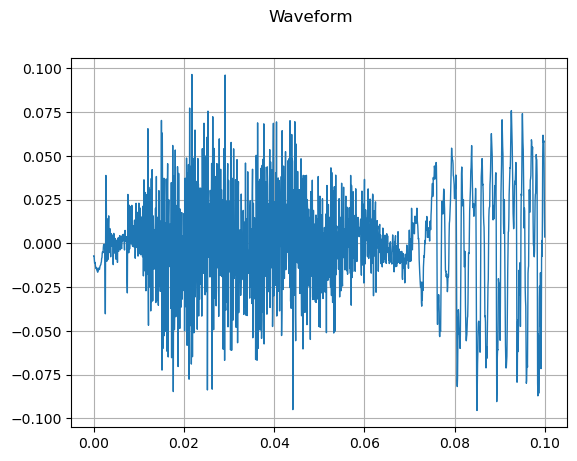

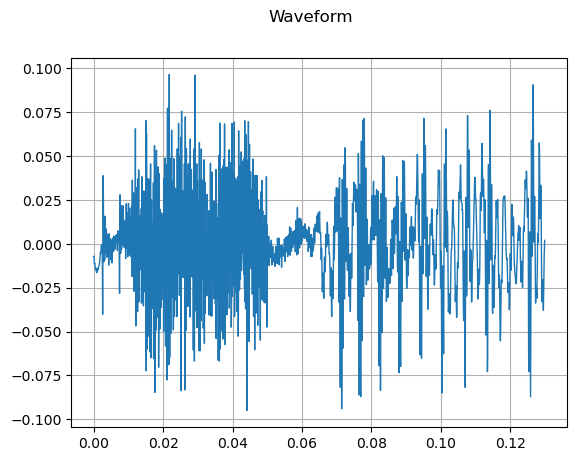

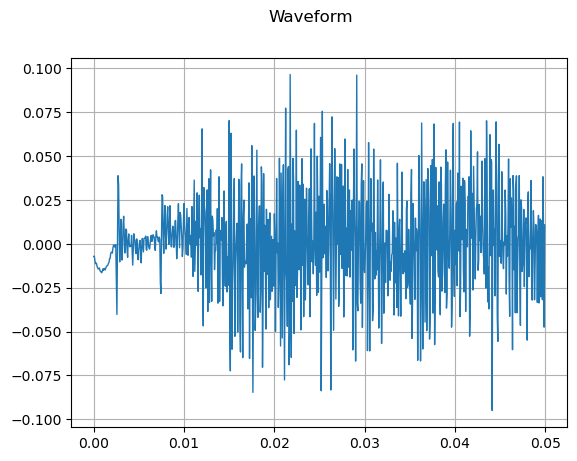

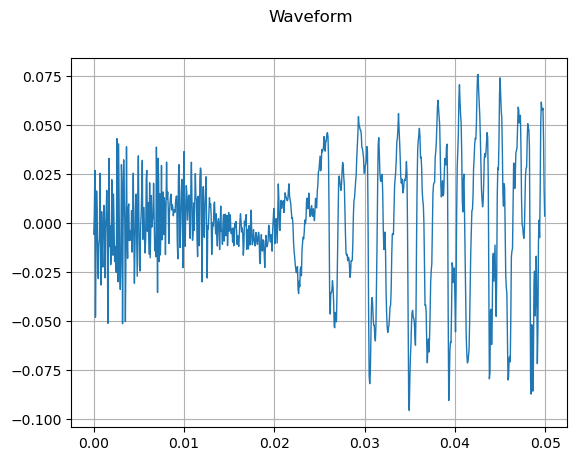

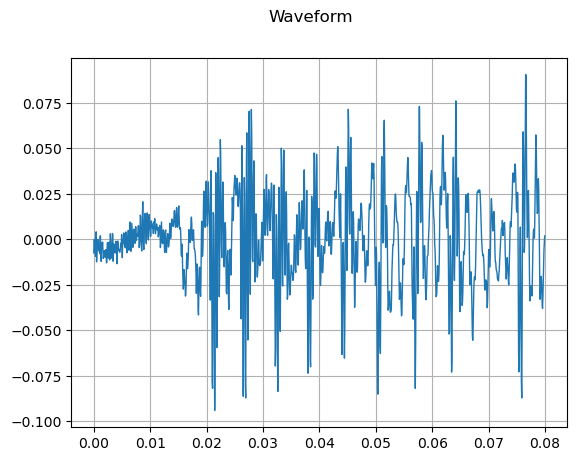

In [89]:
T_name = os.path.join(train_cut_phone_, "103/1240/0002/103-1240-0002-0169.flac")
V_name_1 = os.path.join(train_cut_phone_, "103/1240/0002/103-1240-0002-0170.flac")
V_name_2 = os.path.join(train_cut_phone_, "103/1240/0024/103-1240-0024-0013.flac")

T_data, sample_rate_T = torchaudio.load(T_name, normalize=True)
V_data_1, sample_rate_V = torchaudio.load(V_name_1, normalize=True)
V_data_2, sample_rate_V = torchaudio.load(V_name_2, normalize=True)

data_1 = torch.cat([T_data, V_data_1], dim=1)
data_2 = torch.cat([T_data, V_data_2], dim=1)

plot_waveform(data_1, sample_rate_T)
plot_waveform(data_2, sample_rate_T)

plot_waveform(T_data, sample_rate_T)
plot_waveform(V_data_1, sample_rate_T)
plot_waveform(V_data_2, sample_rate_T)

torchaudio.save("aaa_data_1.wav", data_1, sample_rate_T)
torchaudio.save("aaa_data_2.wav", data_2, sample_rate_T)
torchaudio.save("aaa_T_data.wav", T_data, sample_rate_T)
torchaudio.save("aaa_V_data_1.wav", V_data_1, sample_rate_T)
torchaudio.save("aaa_V_data_2.wav", V_data_2, sample_rate_T)

In [3]:
sibstopsdf = pd.read_csv(os.path.join(src_, "phi-ST-guide.csv"))

In [5]:
S_st = sibstopsdf["pre_startTime"]
S_et = sibstopsdf["pre_endTime"]

In [6]:
S_dur = S_et - S_st

In [12]:
np.mean(S_dur), np.std(S_dur)

(0.09068133728311471, 0.03271727752124411)

(array([ 15.,  62.,   0., 156.,  27., 209., 333.,   0., 343.,   1., 334.,
        281.,   0., 179.,  28., 109.,  79.,   0.,  70.,   7.,  36.,  22.,
          0.,  16.,   0.,  19.,   9.,   0.,   8.,   1.,   3.,   6.,   0.,
          2.,   0.,   3.,   0.,   0.,   2.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   1.]),
 array([0.03 , 0.036, 0.042, 0.048, 0.054, 0.06 , 0.066, 0.072, 0.078,
        0.084, 0.09 , 0.096, 0.102, 0.108, 0.114, 0.12 , 0.126, 0.132,
        0.138, 0.144, 0.15 , 0.156, 0.162, 0.168, 0.174, 0.18 , 0.186,
        0.192, 0.198, 0.204, 0.21 , 0.216, 0.222, 0.228, 0.234, 0.24 ,
        0.246, 0.252, 0.258, 0.264, 0.27 , 0.276, 0.282, 0.288, 0.294,
        0.3  , 0.306, 0.312, 0.318, 0.324, 0.33 ]),
 <BarContainer object of 50 artists>)

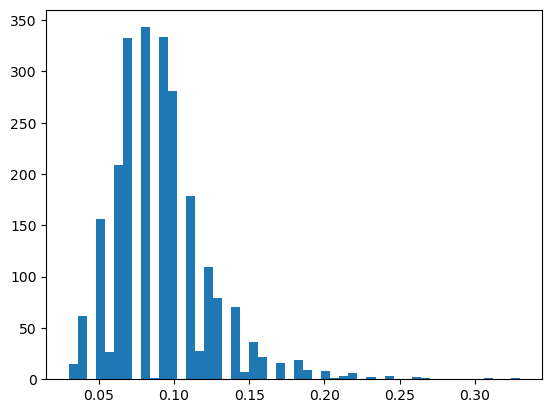

In [10]:
plt.hist(S_dur, bins='auto')

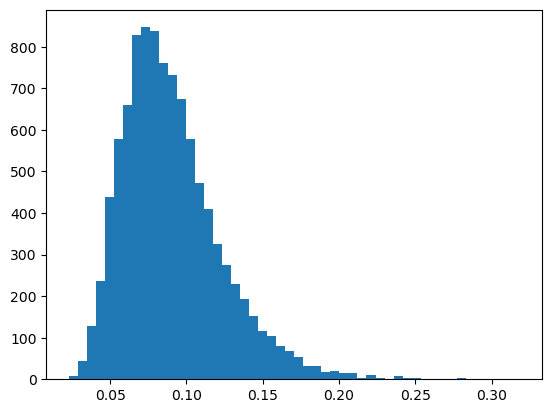

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Given mean and standard deviation
mean = 0.09068133728311471
std = 0.03271727752124411

# Generate a log-normal distribution
sigma = np.sqrt(np.log(1 + (std/mean)**2))
mu = np.log(mean) - 0.5 * sigma**2

# Generate random samples from the log-normal distribution
samples = np.random.lognormal(mean=mu, sigma=sigma, size=10000)

# Plot the histogram of the samples
plt.hist(samples, bins=50)
plt.show()


In [16]:
class SilenceSampler_for_TV: 
    def __init__(self): 
        # mean and std fixed calculated from ST dataset. 
        mean = 0.09068133728311471
        std = 0.03271727752124411

        self.sigma = np.sqrt(np.log(1 + (std/mean)**2))
        self.mu = np.log(mean) - 0.5 * self.sigma**2
    
    def sample(self, size): 
        samples = np.random.lognormal(mean=self.mu, sigma=self.sigma, size=size)
        return samples
    

class WhiteNoiseGen: 
    def __init__(self, sample_rate, amplitude):
        self.sr = sample_rate
        self.amplitude = amplitude
    
    def generate(self, duration): 
        num_samples = int(duration * self.sr)
        noise = torch.randn(num_samples) * self.amplitude
        noise = noise.unsqueeze(0)
        return noise

In [17]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)


def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

## Now we test on level of noise

In [18]:
def plot_many(arrs, labels, save_path, plot_label_dict={"xlabel": "Epoch", "ylabel": "Value", "title": "Value Across Epochs"}): 
    n_steps = arrs[0].shape[0]
    mean_trajs = []
    lower_bounds = []
    upper_bounds = []
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    for arr in arrs: 
        assert arr.shape[0] == n_steps
        mean_traj = np.mean(arr, axis=0)
        sem_arr = sem(arr, axis=0)
        ci_95 = 1.96 * sem_arr
        upper_bound = mean_traj + ci_95
        lower_bound = mean_traj - ci_95
        mean_trajs.append(mean_traj)
        lower_bounds.append(lower_bound)
        upper_bounds.append(upper_bound)

    # Plotting
    plt.figure(figsize=(12, 8))
    for idx, (mean_traj, lower_bound, upper_bound, label) in enumerate(zip(mean_trajs, lower_bounds, upper_bounds, labels)): 
        plt.plot(mean_traj, label=label, color=colors[idx])
        plt.fill_between(range(n_steps), lower_bound, upper_bound, color=colors[idx], alpha=0.2)

    plt.xlabel(plot_label_dict["xlabel"])
    plt.ylabel(plot_label_dict["ylabel"])
    plt.title(plot_label_dict["title"])
    plt.legend()
    plt.grid(True)
    # plt.savefig(save_path)
    # plt.close()

In [19]:
# read in guide file
# guide_file_train = pd.read_csv(train_guide_path)
# guide_file_valid = pd.read_csv(valid_guide_path)
guide_file_test = pd.read_csv(test_guide_path)

# combine guide files
# guide_file = pd.concat([guide_file_train, guide_file_valid, guide_file_test], ignore_index=True, sort=False)
guide_file = guide_file_test

# filtering out is not necessary, since we only include wuid for encoded words
guide_file = guide_file[guide_file["segment_nostress"].isin(["sil", "sp", "spn"])]

In [20]:
sil = guide_file[guide_file["segment_nostress"].isin(["sil"])]
sp = guide_file[guide_file["segment_nostress"].isin(["sp"])]

In [21]:
sil_fns = sil["phone_path"].tolist()
sp_fns = sp["phone_path"].tolist()

In [22]:
sil_maxs = []
sil_mins = []
for fn in sil_fns: 
    wav, sr = torchaudio.load(os.path.join(train_cut_phone_, fn))
    sil_maxs.append(wav.max())
    sil_mins.append(wav.min())

sp_maxs = []
sp_mins = []
for fn in sp_fns: 
    wav, sr = torchaudio.load(os.path.join(train_cut_phone_, fn))
    sp_maxs.append(wav.max())
    sp_mins.append(wav.min())

In [23]:
def plot_tensor_histogram(tensor_list, bins=100, title="Histogram of Tensor Values", xlabel="Value", ylabel="Frequency"):
    # Convert the list of tensors to a list of values
    values = [tensor.item() for tensor in tensor_list]

    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(values, bins=bins, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

In [24]:
np.array(sil_maxs).mean(), np.array(sil_maxs).std()

(0.010987163, 0.016247552)

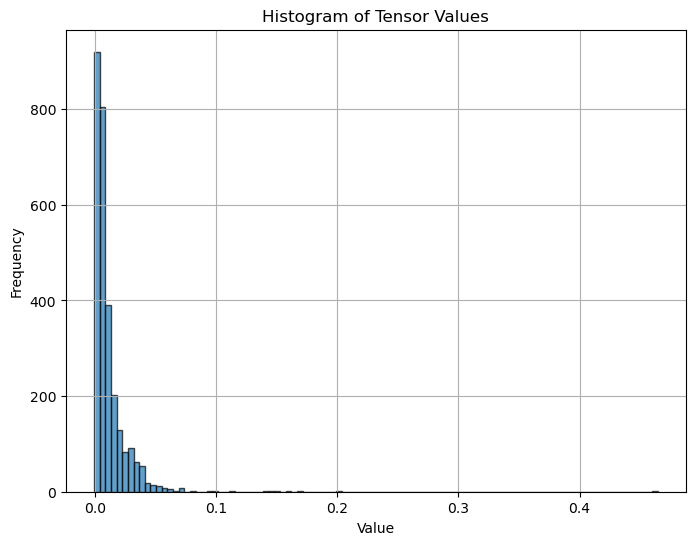

In [25]:
plot_tensor_histogram(sil_maxs)

# This tells us that the average noise level is 0.01! 
This is much higher than 1e-5. And therefore we should switch back to this low level. 

## However
Upon inspection on spectrogram, we found that 5e-4 was roughly the correct level so that the surrounding sounds would not be over-amplified nor ignored. 

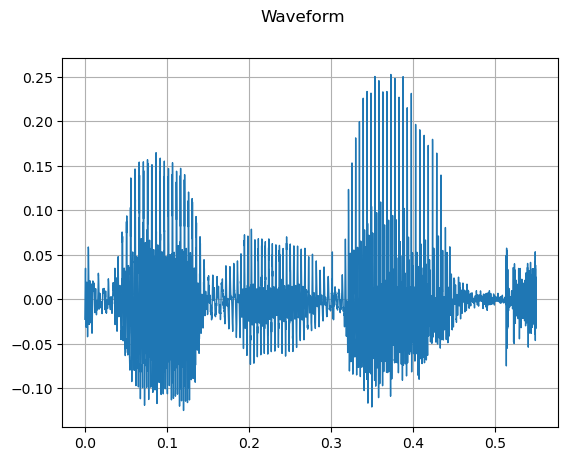

In [26]:
wav, sr = torchaudio.load(os.path.join(train_cut_phone_, "887/123291/0042/887-123291-0042-0064.flac"))
plot_waveform(wav, sr)
# plot_specgram(wav, sample_rate)

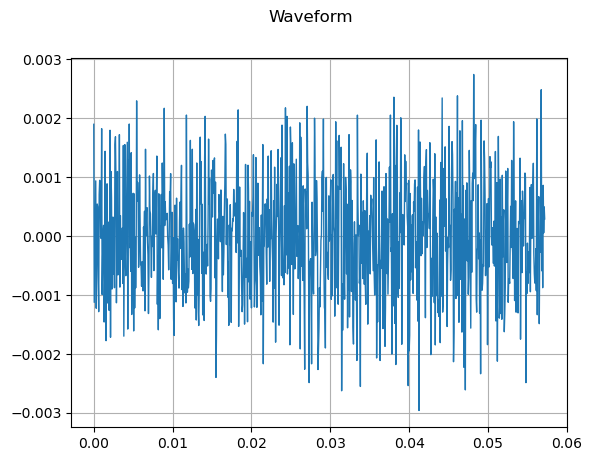

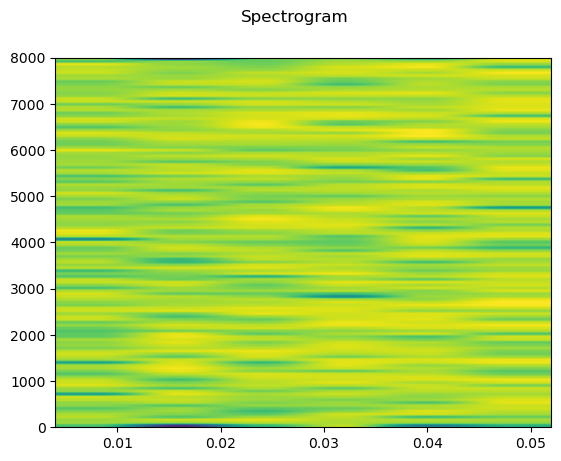

In [27]:
import torchaudio
import torch
import matplotlib.pyplot as plt

# Parameters
durations = SilenceSampler_for_TV().sample(10)
duration = durations[1]  # duration in seconds
sample_rate = 16000  # sample rate in Hz
intensity = 0.001  # intensity of the noise (amplitude scaling factor)

noise_gen = WhiteNoiseGen(sample_rate, intensity)

# Generate white noise
white_noise = noise_gen.generate(duration)


plot_waveform(white_noise, sample_rate)
plot_specgram(white_noise, sample_rate)

# Mel Investigation

In [28]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title, fontsize=24)
    ax.set_ylabel(ylabel, fontdict={"fontsize": 18})
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontsize(18) for label in labels]
    # ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

def plot_spectrogram_lined(specgram, title=None, ylabel="freq_bin", ax=None, flines=None, dlines=None, dlines2=None, burstlines=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title, fontsize=24)
    ax.set_ylabel(ylabel, fontdict={"fontsize": 18})
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontsize(18) for label in labels]
    
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")
    
    # Draw vertical lines at specified x-values
    if flines is not None:
        for x in flines:
            ax.axvline(x=x, color='red', linestyle='-', linewidth=2)
    if dlines is not None:
        for x in dlines:
            ax.axvline(x=x, color='blue', linestyle='--', linewidth=1)
    if dlines2 is not None:
        for x in dlines2:
            ax.axvline(x=x, color='orange', linestyle='--', linewidth=1)
    if burstlines is not None:
        for x in burstlines:
            ax.axvline(x=x, color='purple', linestyle='dashdot', linewidth=1)

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, flines=None, dlines=None, dlines2=None, burstlines=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    # Draw vertical lines at specified x-values
    ax = axes[0]
    if flines is not None:
        for x in flines:
            ax.axvline(x=x, color='red', linestyle='-', linewidth=2)
    if dlines is not None:
        for x in dlines:
            ax.axvline(x=x, color='blue', linestyle='--', linewidth=1)
    if dlines2 is not None:
        for x in dlines2:
            ax.axvline(x=x, color='orange', linestyle='--', linewidth=1)
    if burstlines is not None:
        for x in burstlines:
            ax.axvline(x=x, color='purple', linestyle='dashdot', linewidth=1)
    

def frame_to_time(frame_index, sr=16000, hop_length=200):
    return frame_index * hop_length / sr

In [29]:
guide_file_valid = pd.read_csv(valid_guide_path)

In [30]:
REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64
mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                    n_fft=N_FFT, n_mels=N_MELS, 
                    # normalizer=Normalizer.no_norm,
                    # denormalizer=DeNormalizer.no_norm)
                    normalizer=Normalizer.norm_mvn, 
                    denormalizer=DeNormalizer.norm_mvn)

mytrans_nonorm = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                    n_fft=N_FFT, n_mels=N_MELS, 
                    normalizer=Normalizer.no_norm,
                    denormalizer=DeNormalizer.no_norm)
                    # normalizer=Normalizer.norm_mvn, 
                    # denormalizer=DeNormalizer.norm_mvn)

In [31]:
for rownum in range(guide_file_valid.shape[0]): 
    row = guide_file_valid.iloc[rownum]
    if guide_file_valid.iloc[rownum]["segment_nostress"]in ["S"] and guide_file_valid.iloc[rownum + 1]["segment_nostress"] in ["P", "T", "K"]: 
        print(f"""pre_name = os.path.join(train_cut_phone_, "{row["phone_path"]}")
T_name = os.path.join(train_cut_phone_, "{guide_file_valid.iloc[rownum + 1]["phone_path"]}")
V_name_1 = os.path.join(train_cut_phone_, "{guide_file_valid.iloc[rownum + 2]["phone_path"]}")""")
        print()
    if rownum > 2000: 
        break

pre_name = os.path.join(train_cut_phone_, "103/1240/0000/103-1240-0000-0056.flac")
T_name = os.path.join(train_cut_phone_, "103/1240/0000/103-1240-0000-0057.flac")
V_name_1 = os.path.join(train_cut_phone_, "103/1240/0000/103-1240-0000-0058.flac")

pre_name = os.path.join(train_cut_phone_, "103/1240/0000/103-1240-0000-0136.flac")
T_name = os.path.join(train_cut_phone_, "103/1240/0000/103-1240-0000-0137.flac")
V_name_1 = os.path.join(train_cut_phone_, "103/1240/0000/103-1240-0000-0138.flac")

pre_name = os.path.join(train_cut_phone_, "103/1240/0001/103-1240-0001-0131.flac")
T_name = os.path.join(train_cut_phone_, "103/1240/0001/103-1240-0001-0132.flac")
V_name_1 = os.path.join(train_cut_phone_, "103/1240/0001/103-1240-0001-0133.flac")

pre_name = os.path.join(train_cut_phone_, "103/1240/0001/103-1240-0001-0190.flac")
T_name = os.path.join(train_cut_phone_, "103/1240/0001/103-1240-0001-0191.flac")
V_name_1 = os.path.join(train_cut_phone_, "103/1240/0001/103-1240-0001-0192.flac")

pre_name

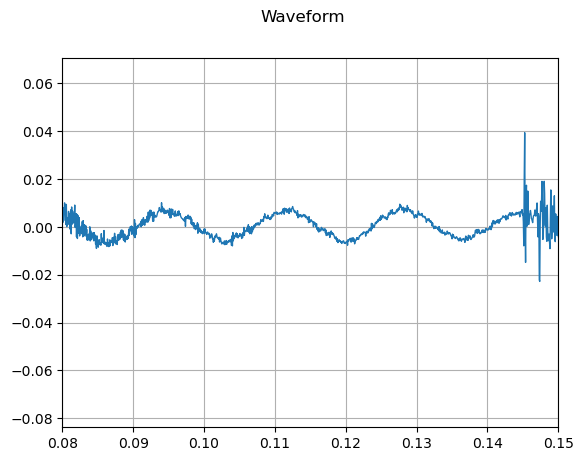

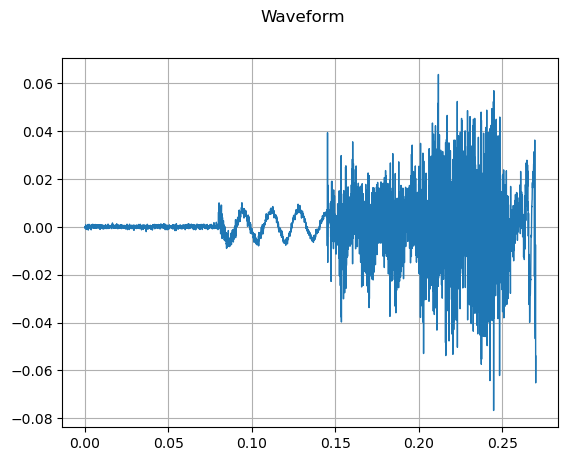

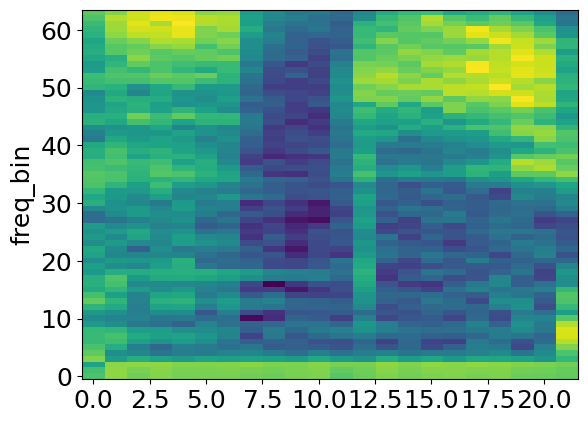

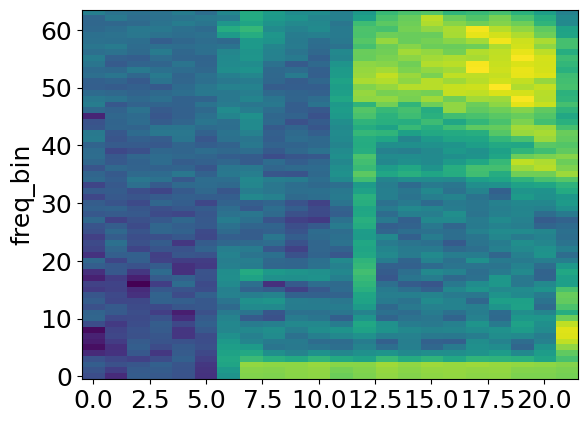

In [32]:
# pre_name = os.path.join(train_cut_phone_, "103/1240/0002/103-1240-0002-0016.flac")
# T_name = os.path.join(train_cut_phone_, "103/1240/0002/103-1240-0002-0017.flac")
# V_name_1 = os.path.join(train_cut_phone_, "103/1240/0002/103-1240-0002-0018.flac")
pre_name = os.path.join(train_cut_phone_, "103/1240/0011/103-1240-0011-0009.flac")
T_name = os.path.join(train_cut_phone_, "103/1240/0011/103-1240-0011-0010.flac")
V_name_1 = os.path.join(train_cut_phone_, "103/1240/0011/103-1240-0011-0011.flac")

pre_data, sample_rate_pre = torchaudio.load(pre_name, normalize=True)
T_data, sample_rate_T = torchaudio.load(T_name, normalize=True)
V_data_1, sample_rate_V = torchaudio.load(V_name_1, normalize=True)
# V_data_2, sample_rate_V = torchaudio.load(V_name_2, normalize=True)

sample_rate = 16000  # sample rate in Hz
intensity = 5e-4  # intensity of the noise (amplitude scaling factor)

noise_gen = WhiteNoiseGen(sample_rate, intensity)

# Generate white noise
white_noise = noise_gen.generate(pre_data.shape[1] / sample_rate_pre)

data_1 = torch.cat([pre_data, T_data, V_data_1], dim=1)
data_2 = torch.cat([white_noise, T_data, V_data_1], dim=1)

plot_waveform(data_1, sample_rate_T, xlim=(0.08, 0.15))
plot_waveform(data_2, sample_rate_T)

mel_1 = mytrans(data_1)
mel_2 = mytrans(data_2)

plot_spectrogram_lined(mel_1.T)
plot_spectrogram_lined(mel_2.T)

mel_1_nonorm = mytrans_nonorm(data_1)
mel_2_nonorm = mytrans_nonorm(data_2)

# plot_waveform(T_data, sample_rate_T)
# plot_specgram(T_data, sample_rate_T)

# plot_waveform(pre_data, sample_rate_T)
# plot_waveform(V_data_1, sample_rate_T)
# plot_waveform(V_data_2, sample_rate_T)

# torchaudio.save("001_data_1.wav", data_1, sample_rate_T)
# torchaudio.save("001_data_2.wav", data_2, sample_rate_T)
# torchaudio.save("aaa_T_data.wav", T_data, sample_rate_T)
# torchaudio.save("aaa_V_data_1.wav", V_data_1, sample_rate_T)
# torchaudio.save("aaa_V_data_2.wav", V_data_2, sample_rate_T)

In [33]:
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

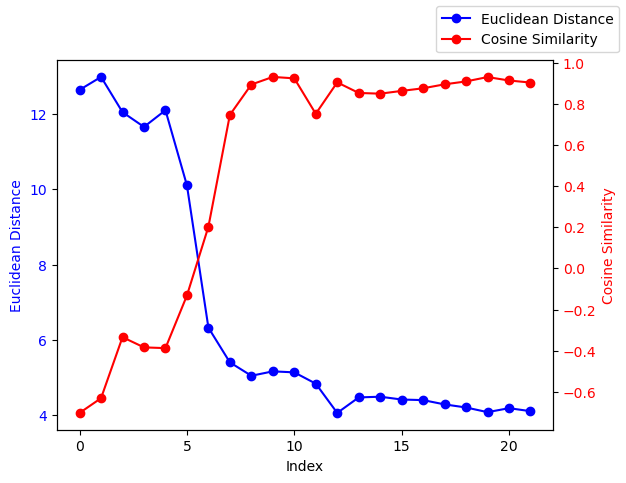

In [34]:
eucd = []
cosd = []
for i in range(len(mel_1)): 
    eucd.append(euclidean_distance(mel_1[i].numpy(), mel_2[i].numpy()))
    cosd.append(F.cosine_similarity(mel_1[i].unsqueeze(0), mel_2[i].unsqueeze(0)).item())

fig, ax1 = plt.subplots()

ax1.plot(eucd, label='Euclidean Distance', color='blue', marker="o")
ax1.set_xlabel('Index')
ax1.set_ylabel('Euclidean Distance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')


ax2 = ax1.twinx()
ax2.plot(cosd, label='Cosine Similarity', color='red', marker="o")
ax2.set_ylabel('Cosine Similarity', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.legend()
plt.show()

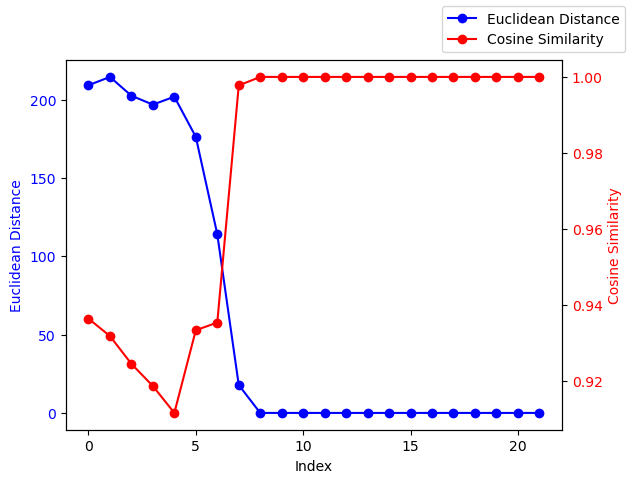

In [35]:
eucd = []
cosd = []
for i in range(len(mel_1_nonorm)): 
    eucd.append(euclidean_distance(mel_1_nonorm[i].numpy(), mel_2_nonorm[i].numpy()))
    cosd.append(F.cosine_similarity(mel_1_nonorm[i].unsqueeze(0), mel_2_nonorm[i].unsqueeze(0)).item())

fig, ax1 = plt.subplots()

ax1.plot(eucd, label='Euclidean Distance', color='blue', marker="o")
ax1.set_xlabel('Index')
ax1.set_ylabel('Euclidean Distance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(cosd, label='Cosine Similarity', color='red', marker="o")
ax2.set_ylabel('Cosine Similarity', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.legend()
plt.show()

In [36]:
def generate_harmonic_noise(duration, sample_rate=16000, f0=60, amplitude=0.006, oscillation_amplitude=0.0001):
    t = np.linspace(0, duration, int(sample_rate*duration), endpoint=False)  # Time axis
    # Generate the dominant F0 sinusoid
    f0_signal = amplitude * np.sin(2 * np.pi * f0 * t)
    # Generate small random oscillations (noise)
    random_oscillations = oscillation_amplitude * np.random.normal(0, 1, len(t))
    # Combine the two
    combined_signal = f0_signal + random_oscillations
    return torch.tensor(combined_signal, dtype=torch.float32).unsqueeze(0)

# Test the validity of our new noise

In [37]:
def plot_spectrogram_one(specgram, title=None, ylabel="freq_bin", ax=None, vmin=None, vmax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title, fontsize=24)
    ax.set_ylabel(ylabel)
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontsize(18) for label in labels]
    # ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest", vmin=vmin, vmax=vmax)

def plot_spectrogram_both(spectrogram_1, spectrogram_2, title=None, ylabel="freq_bin"):
    vmin = min(mel_1.min(), mel_2.min())
    vmax = max(mel_1.max(), mel_2.max())
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    plot_spectrogram_one(spectrogram_1, title=title, ylabel=ylabel, ax=ax1, vmin=vmin, vmax=vmax)
    plot_spectrogram_one(spectrogram_2, title=title, ylabel=ylabel, ax=ax2, vmin=vmin, vmax=vmax)

/tmp/ipykernel_1849719/1701074197.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))


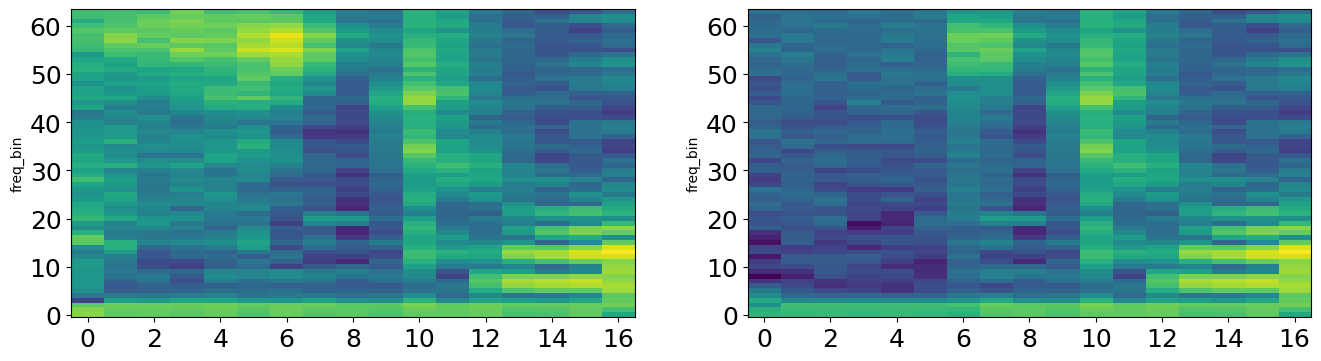

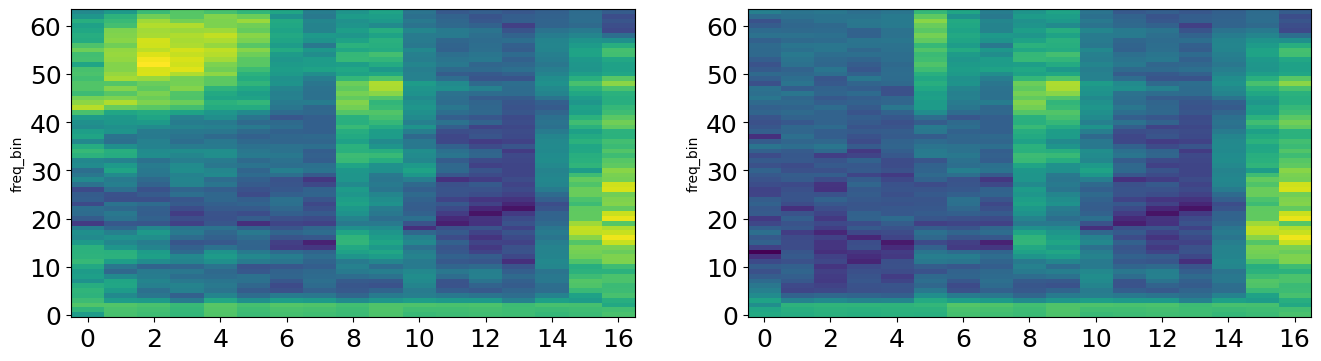

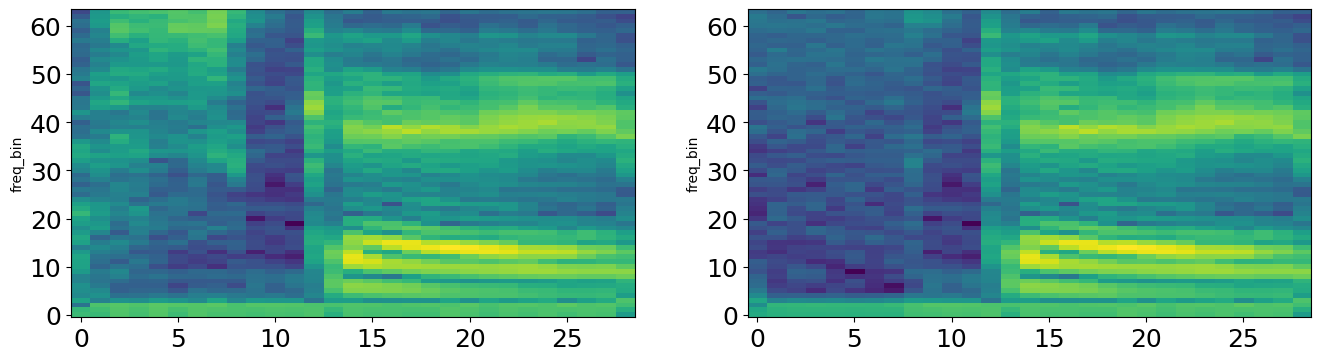

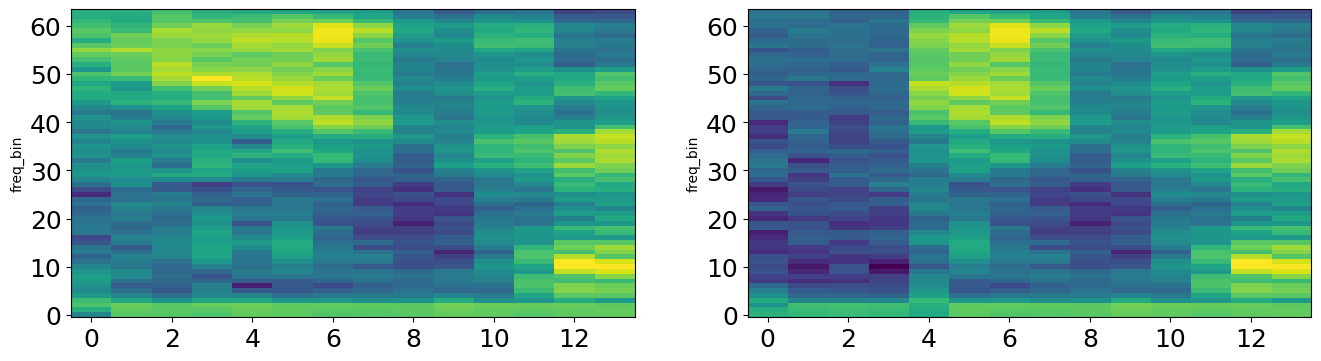

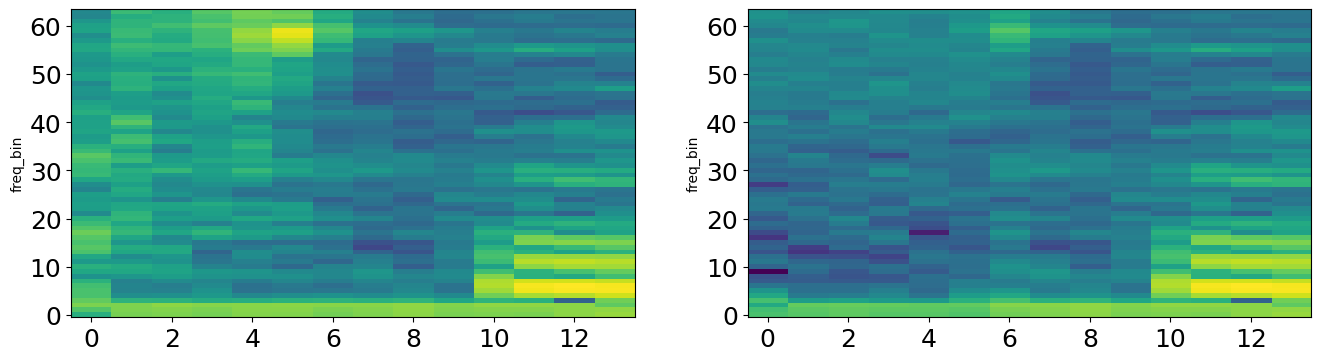

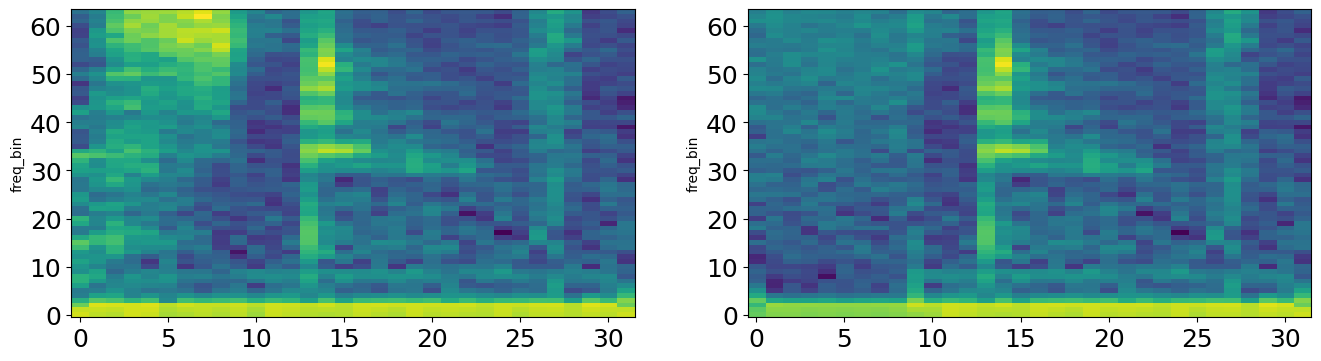

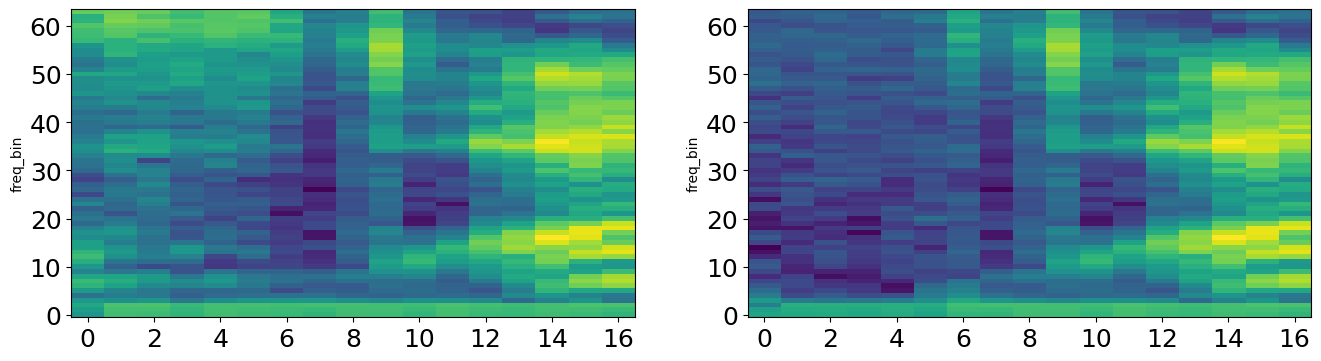

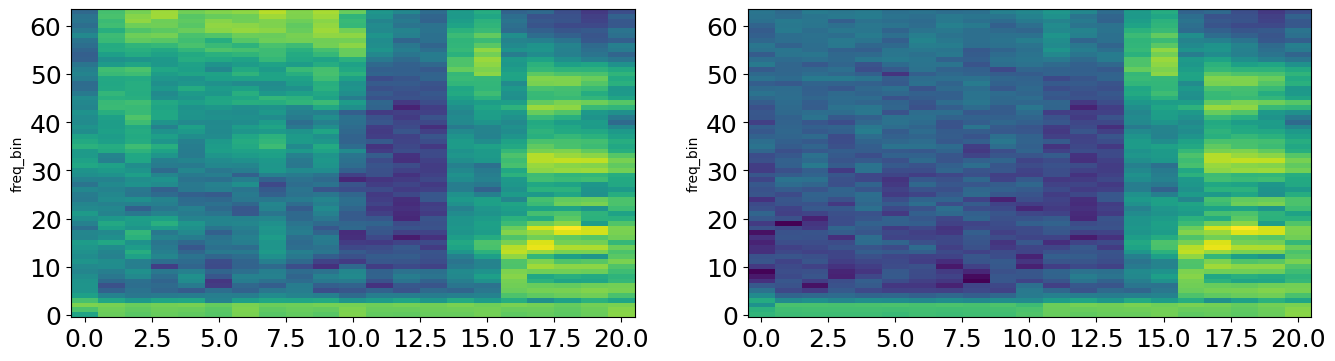

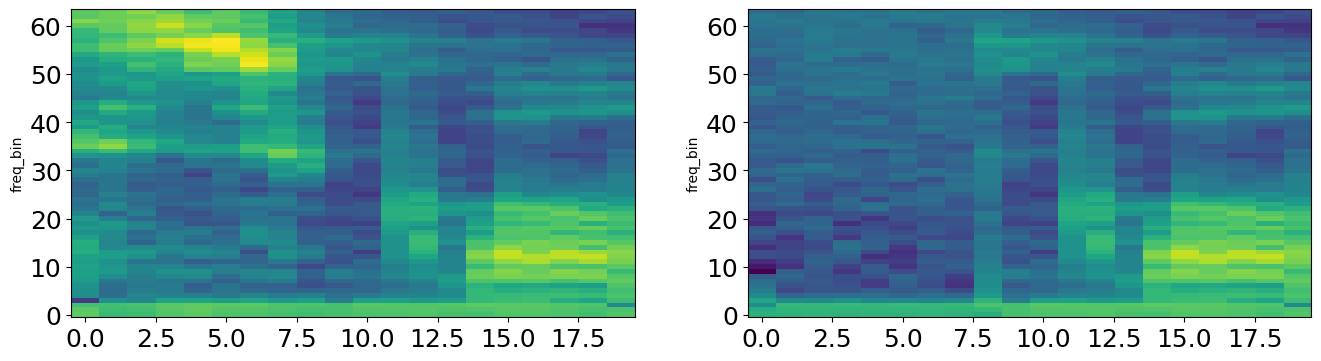

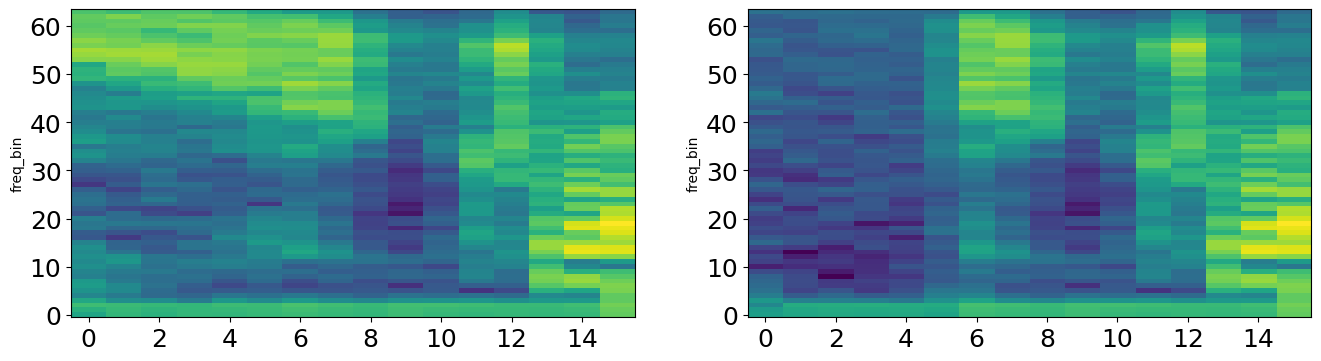

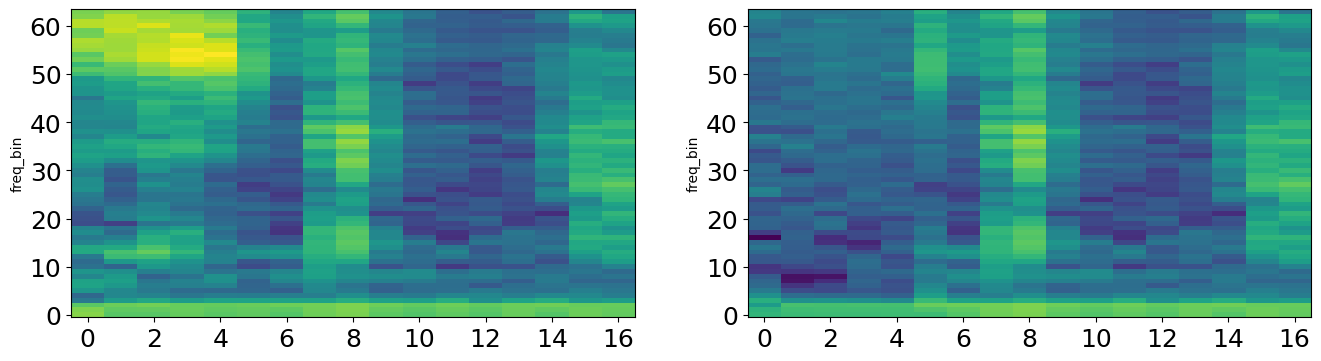

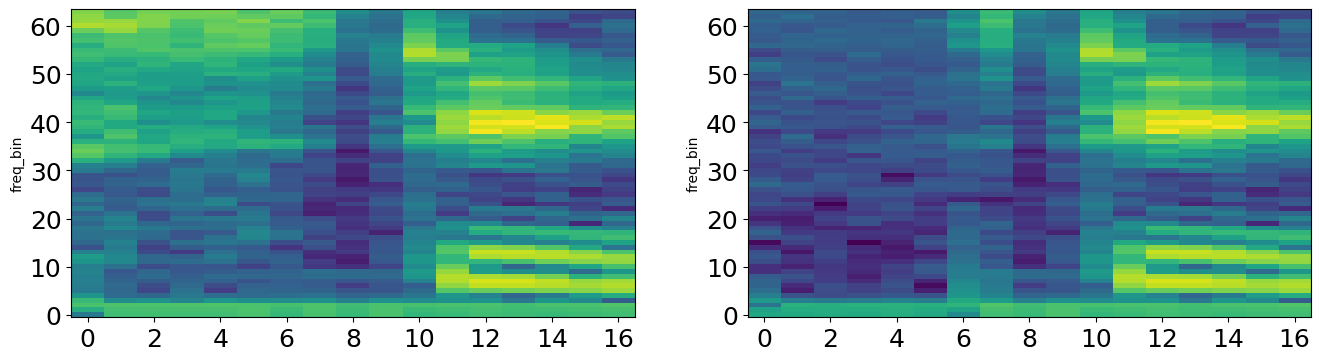

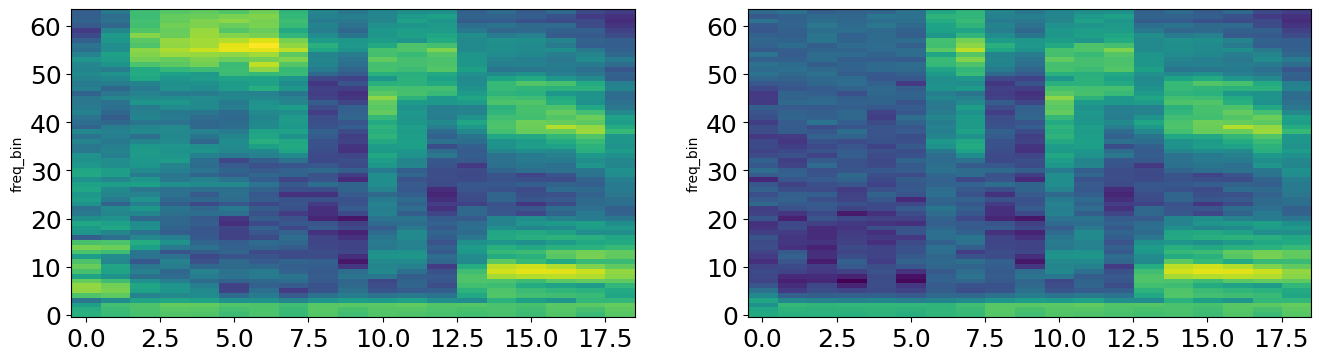

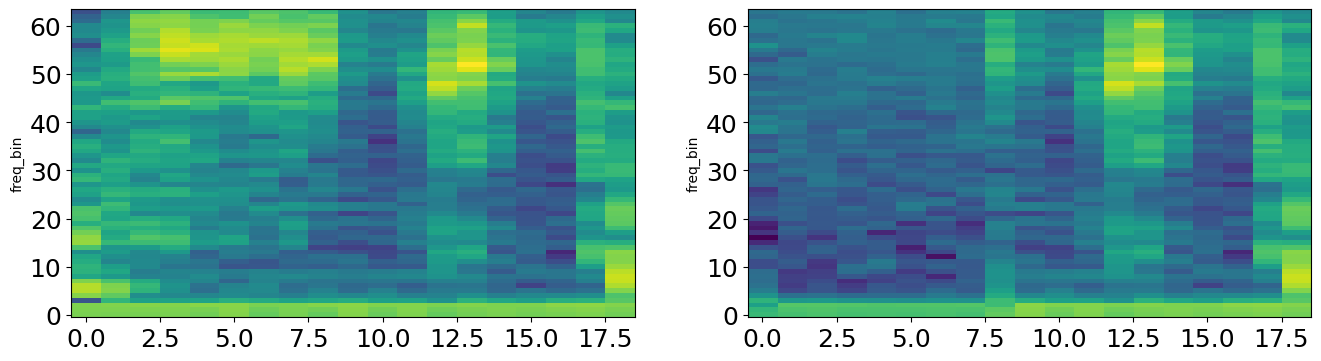

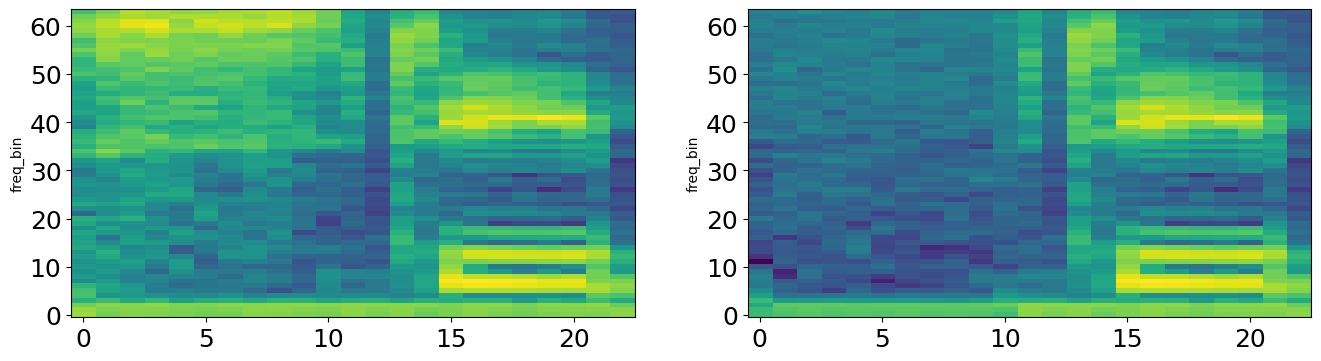

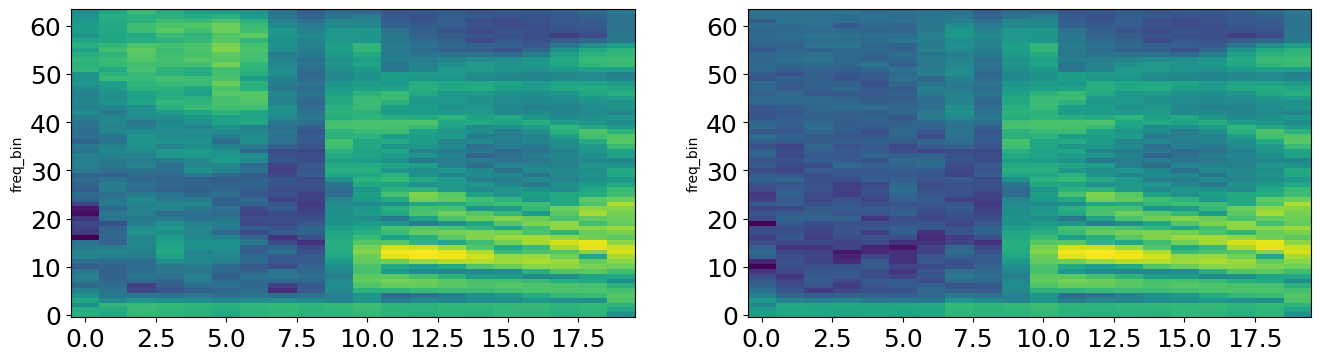

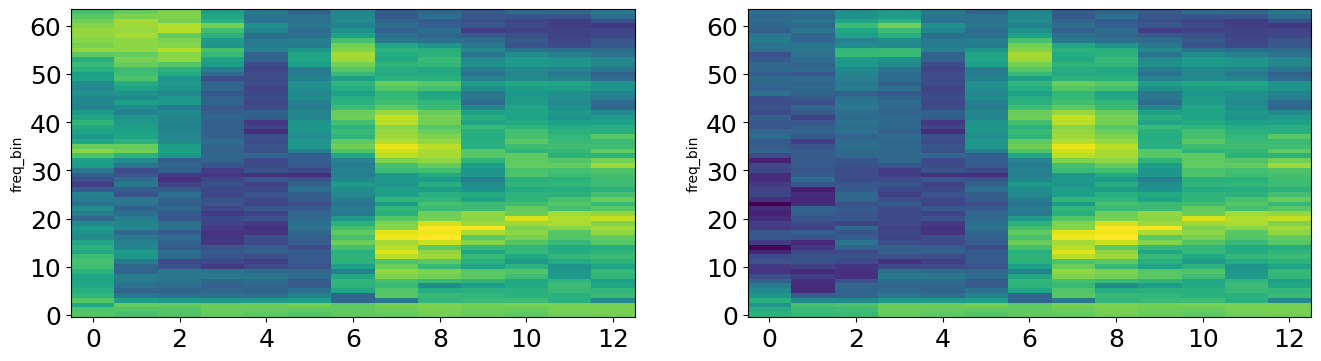

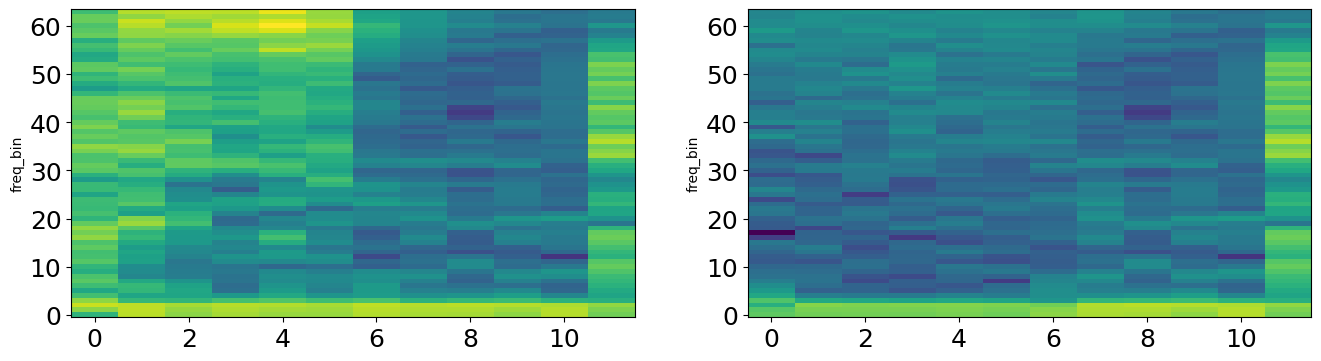

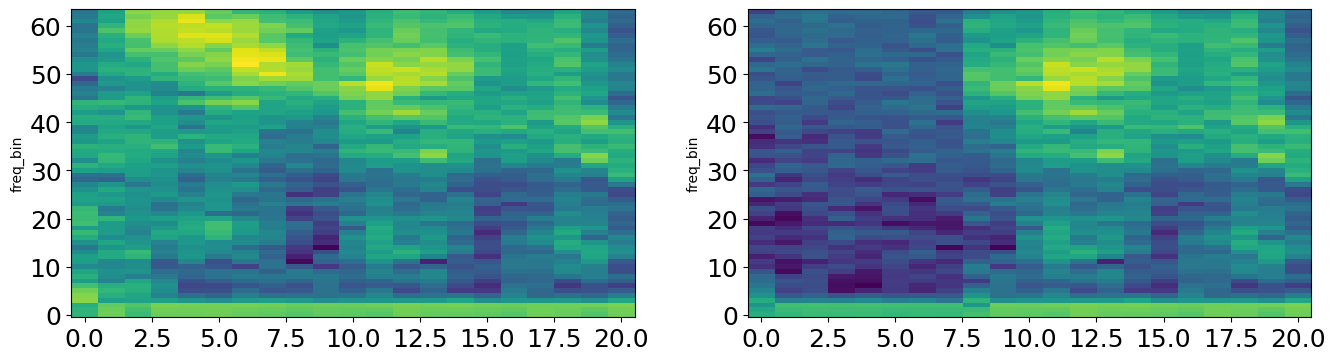

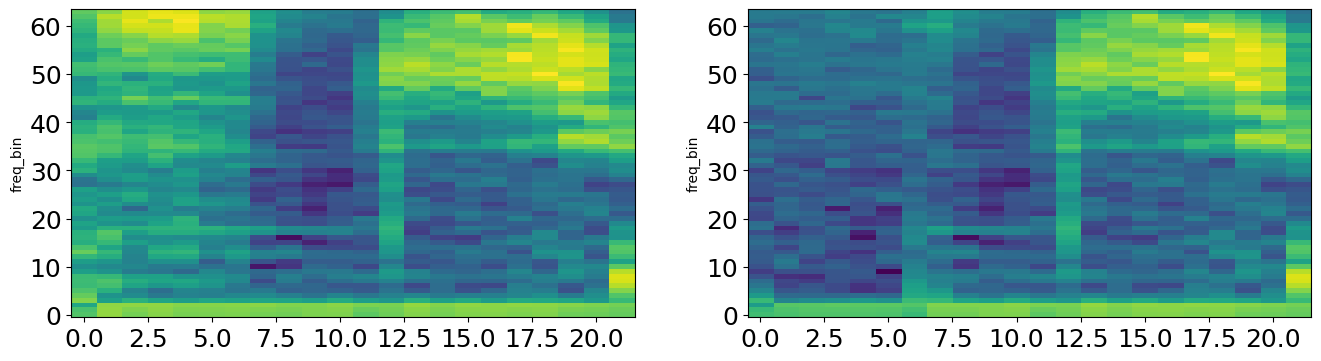

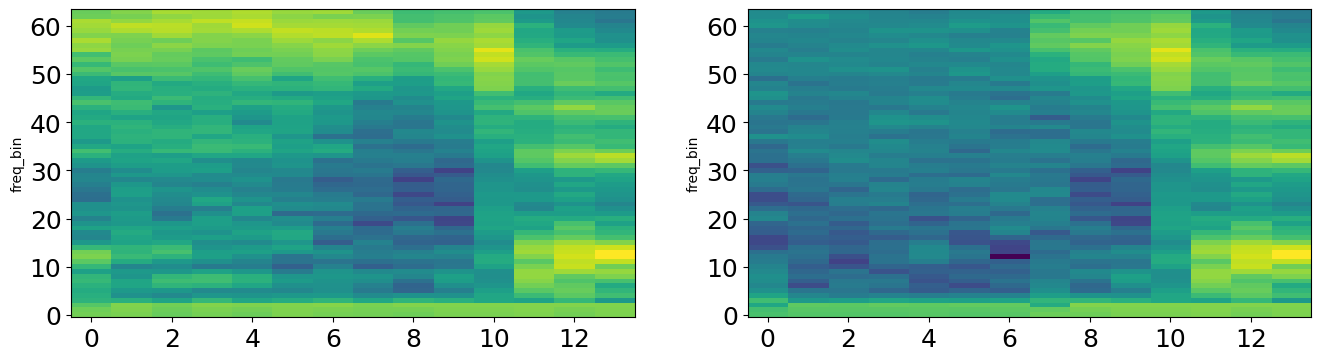

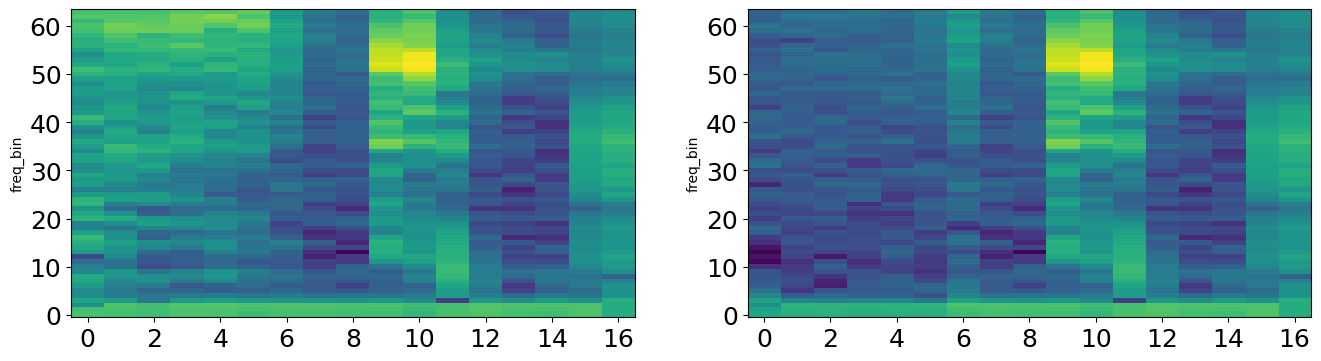

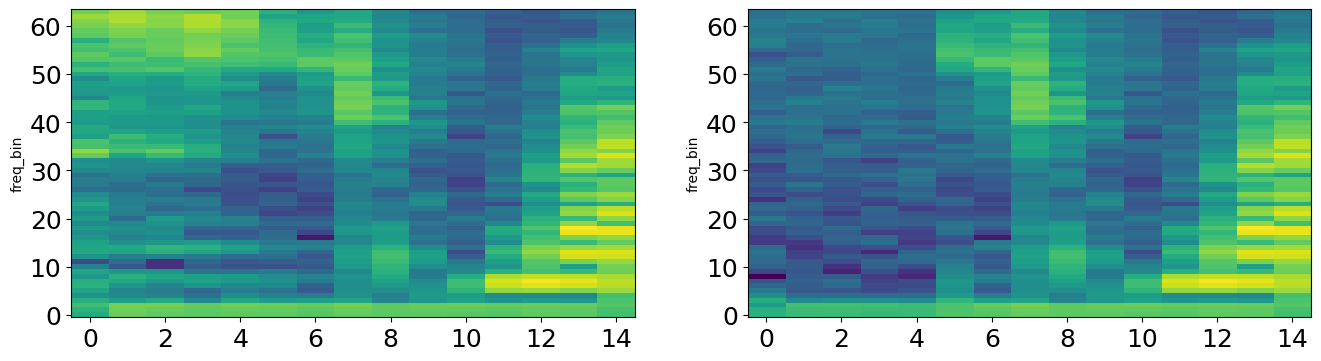

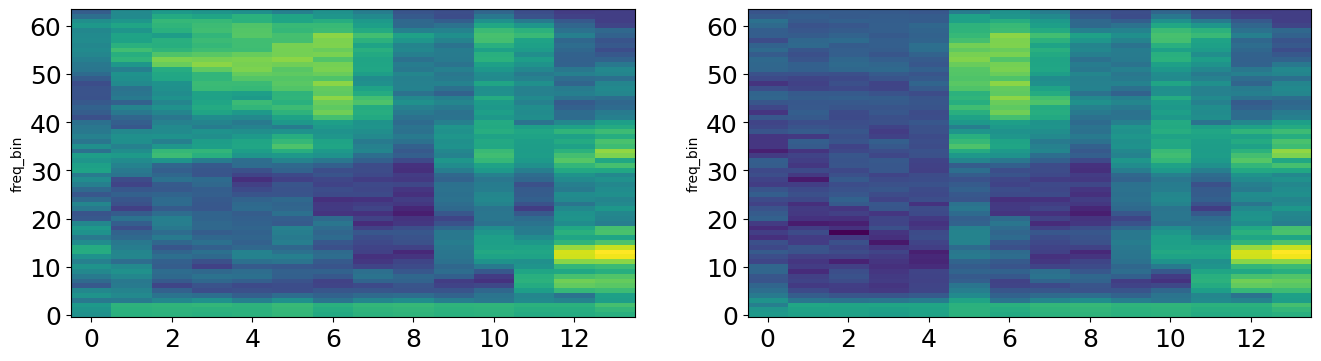

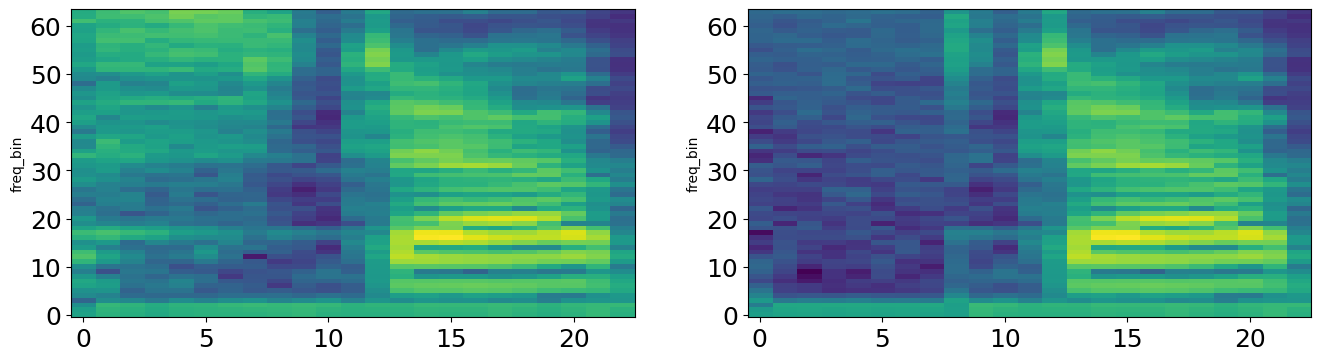

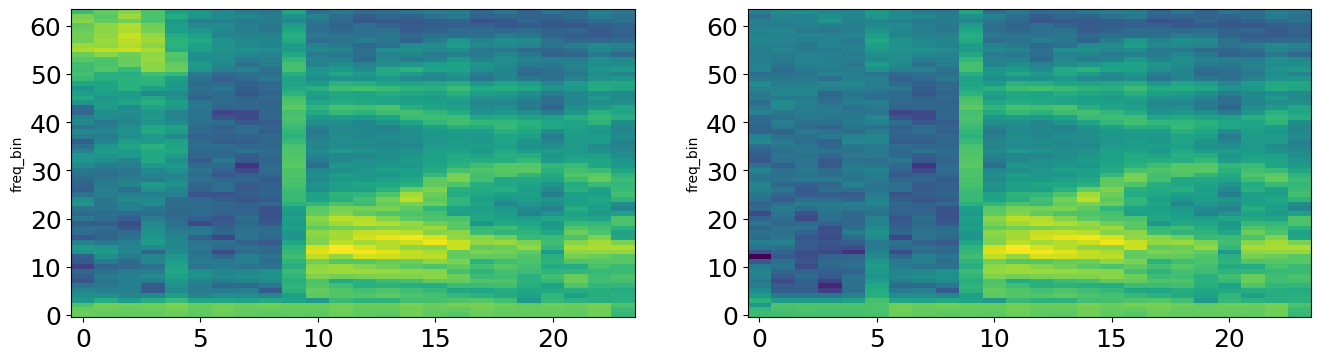

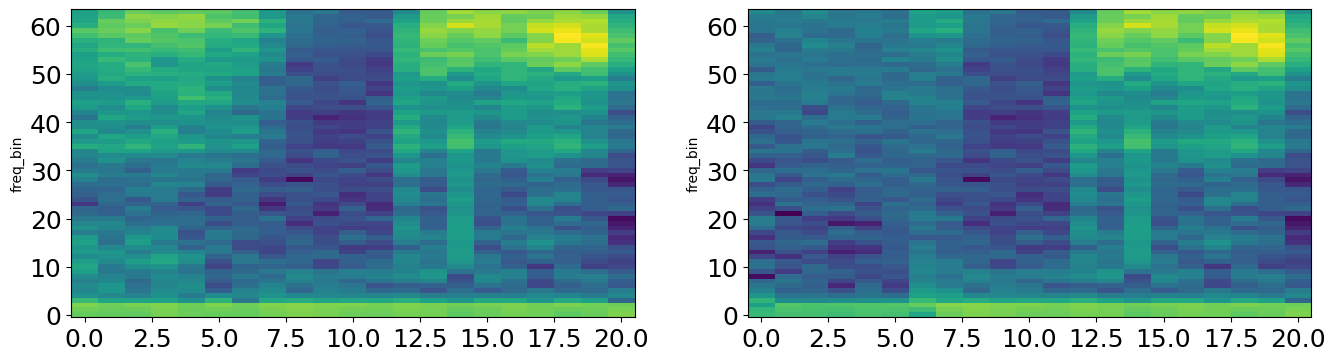

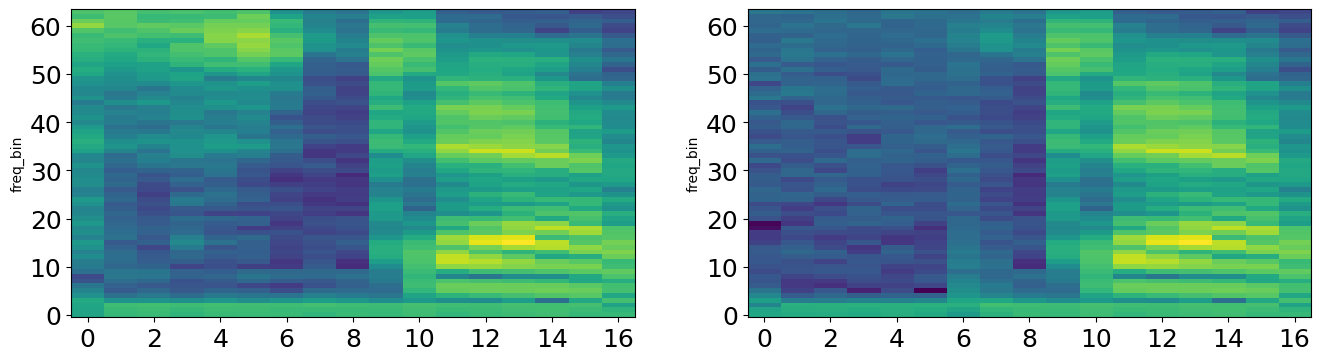

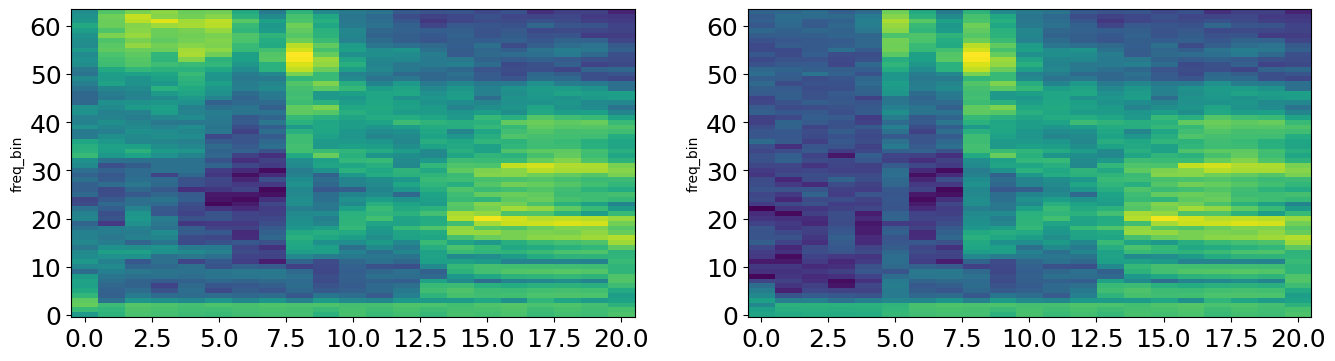

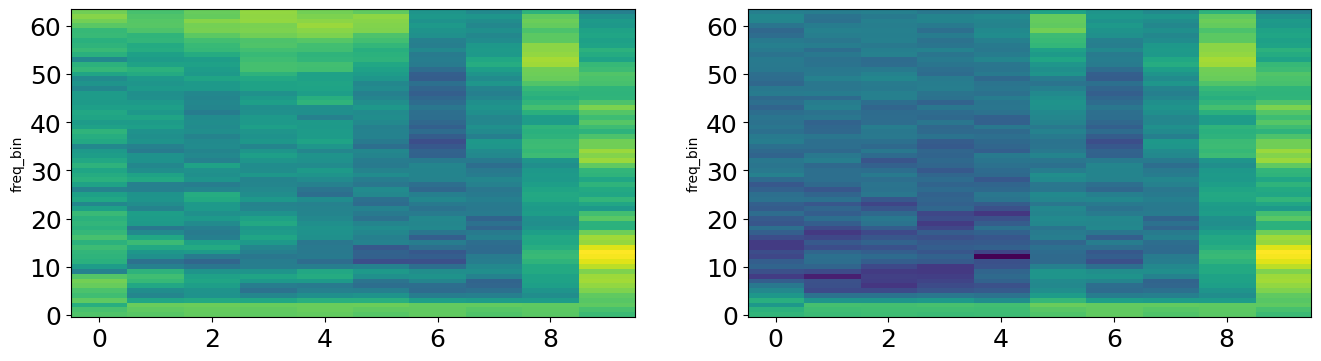

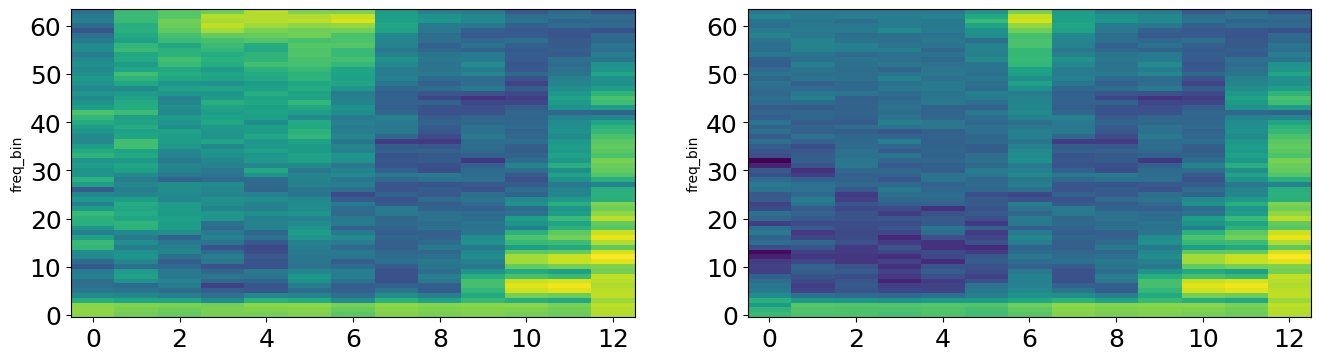

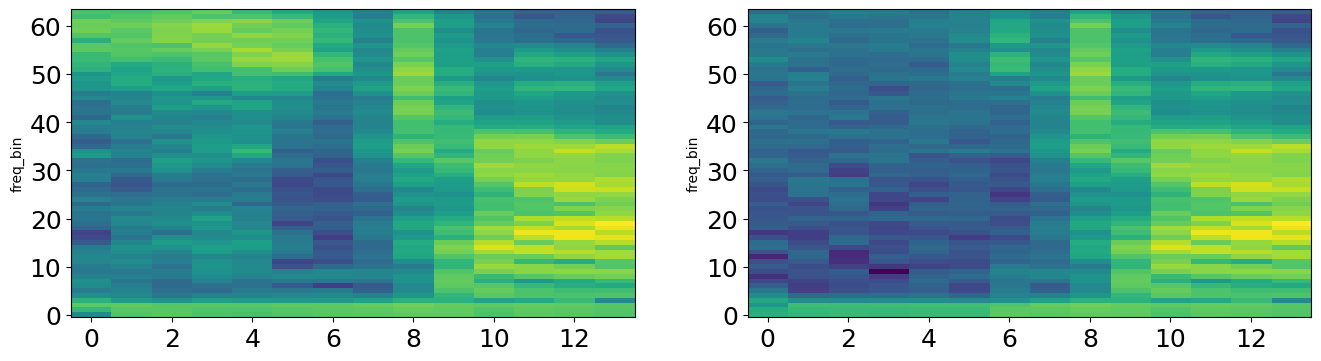

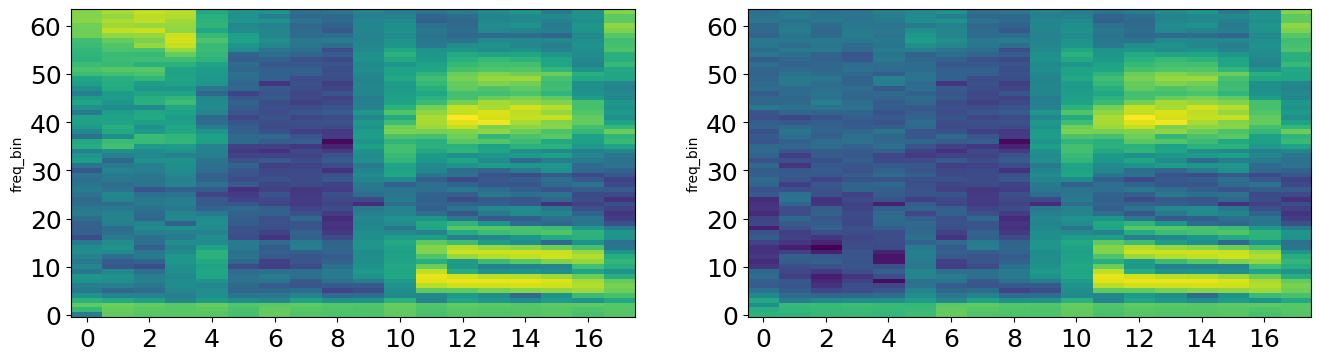

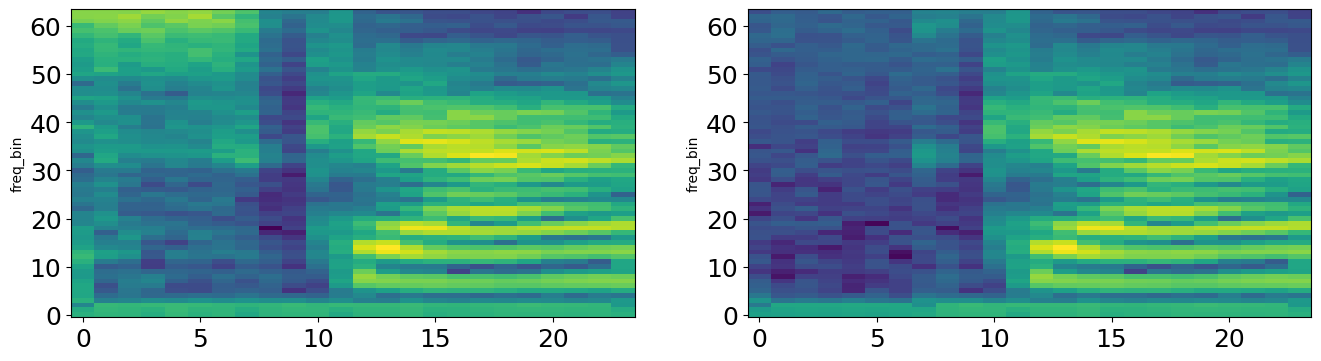

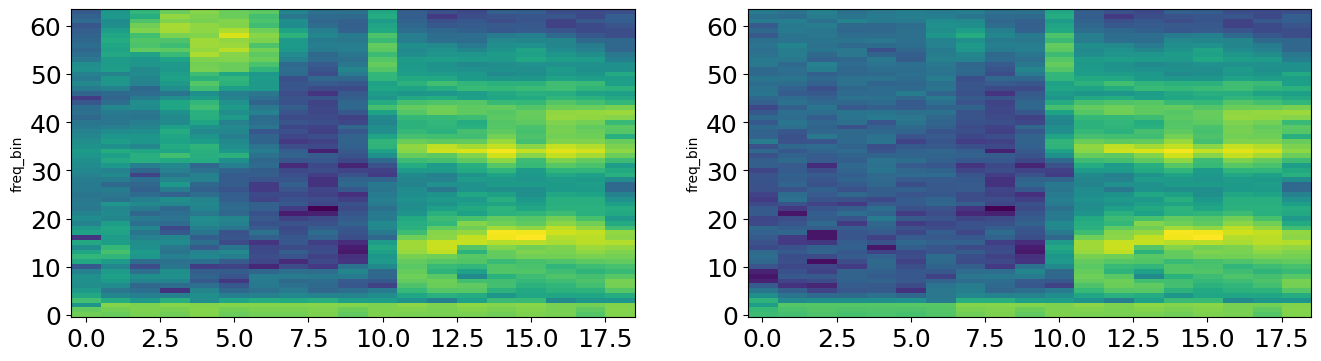

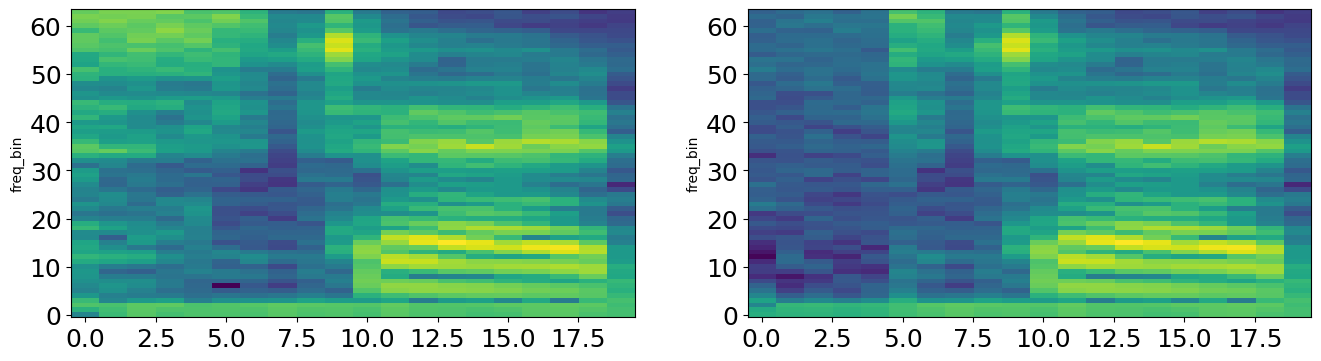

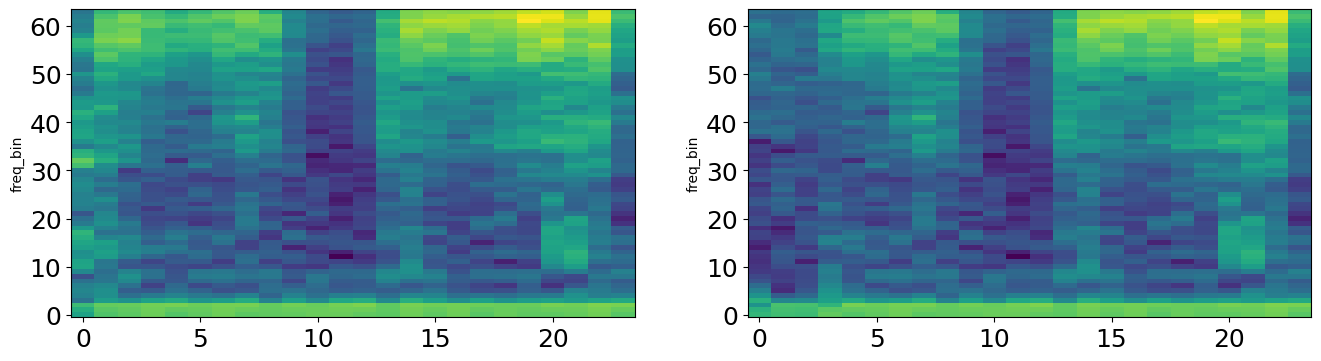

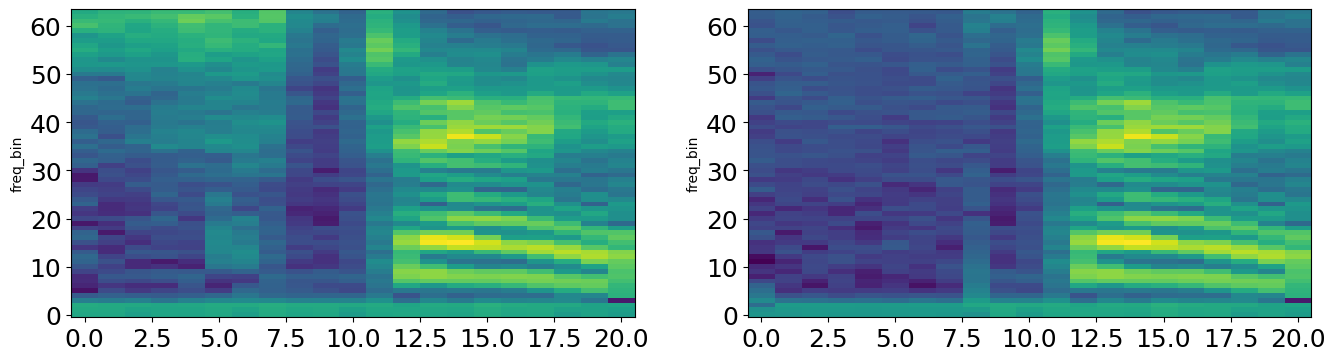

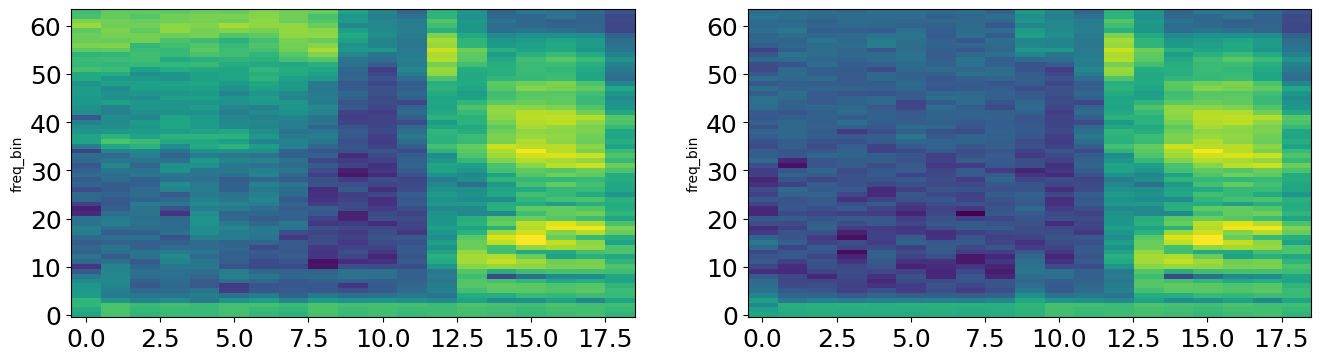

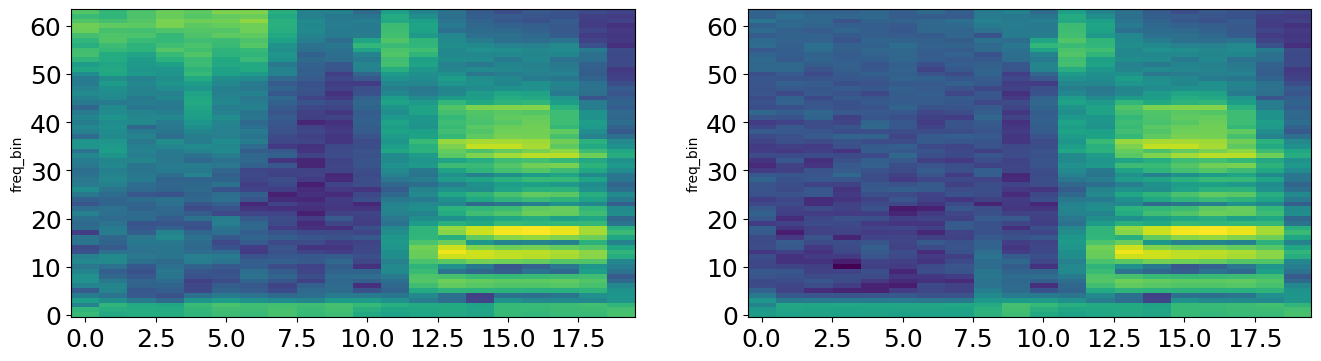

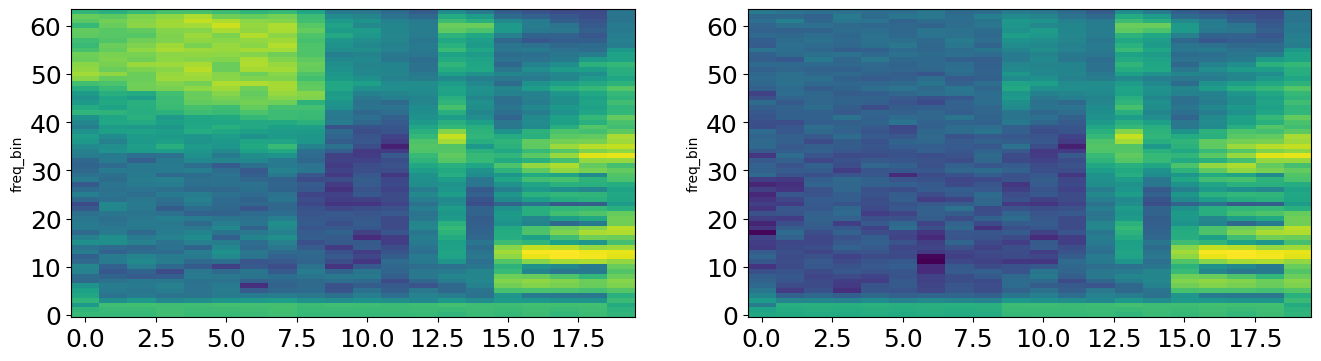

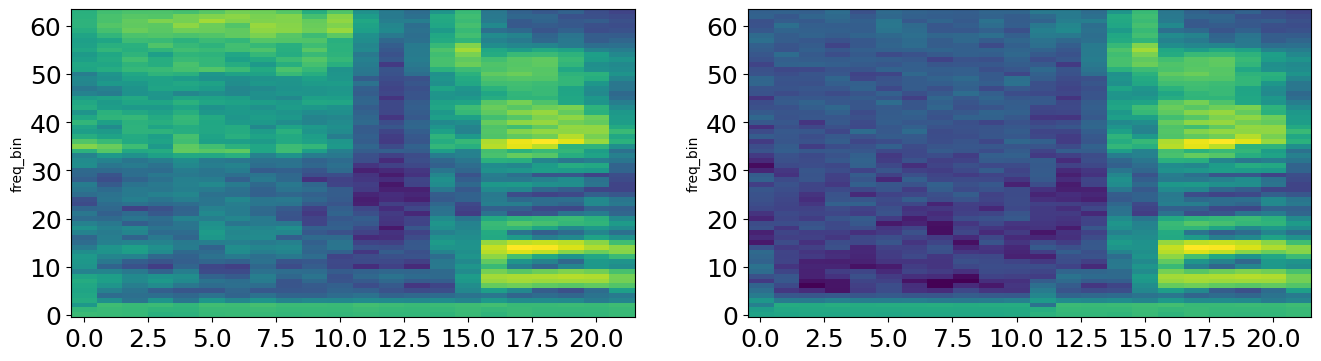

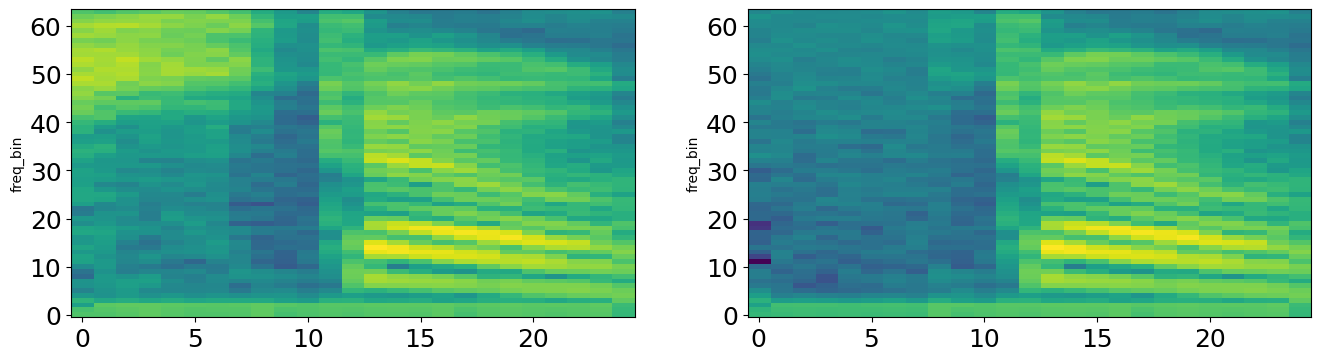

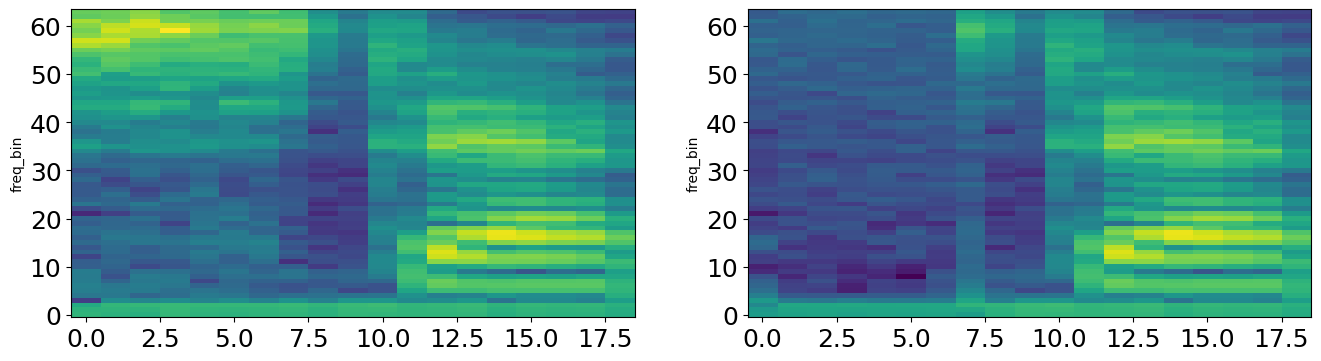

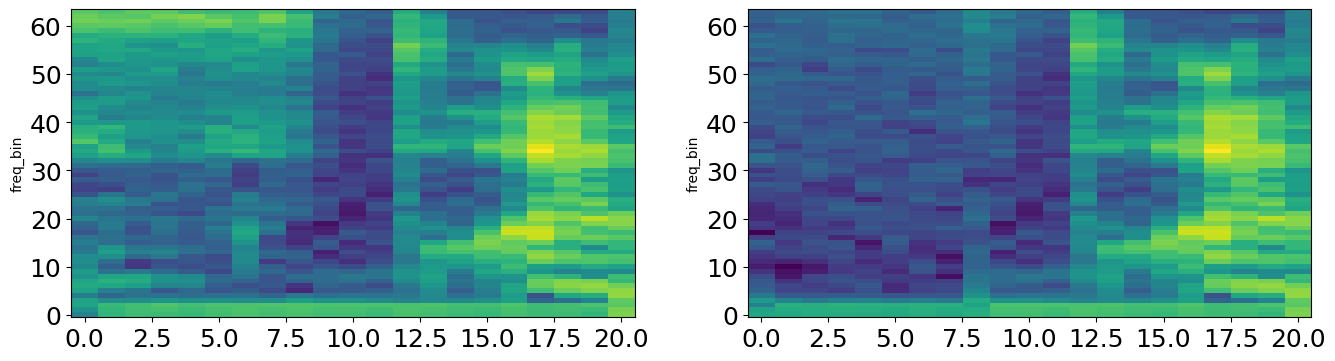

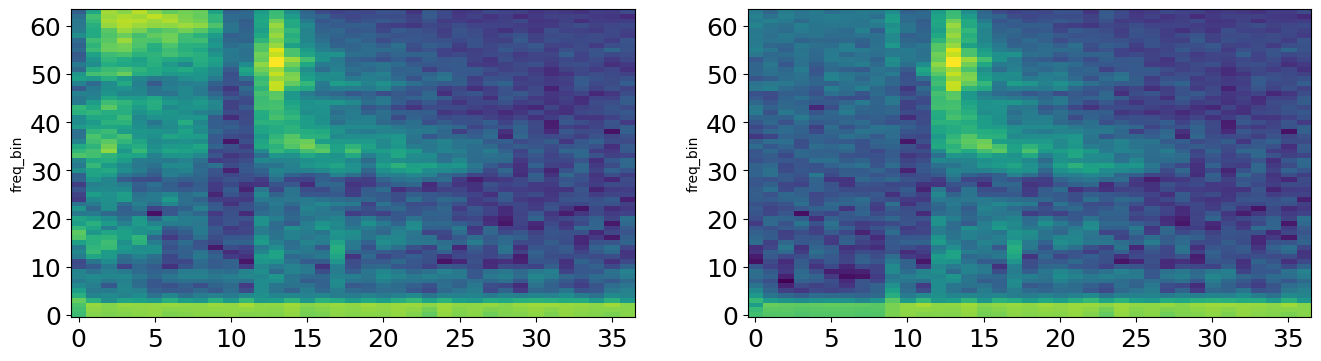

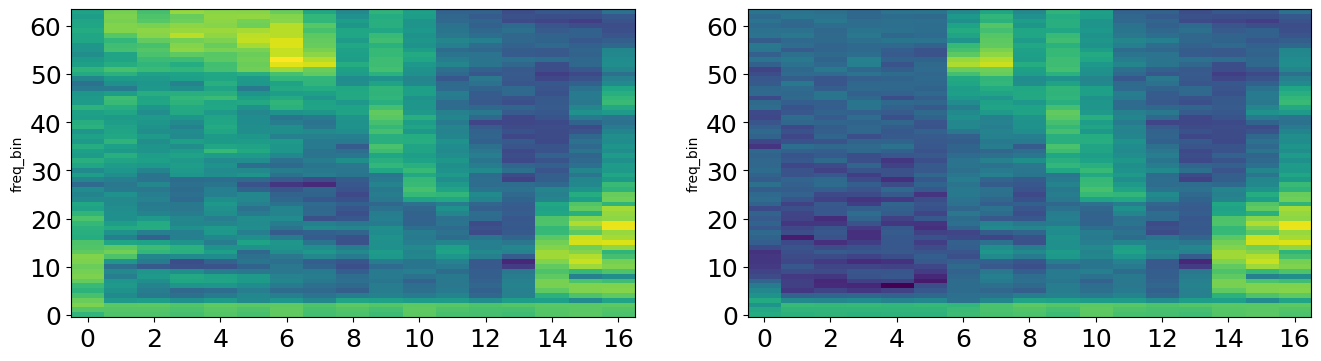

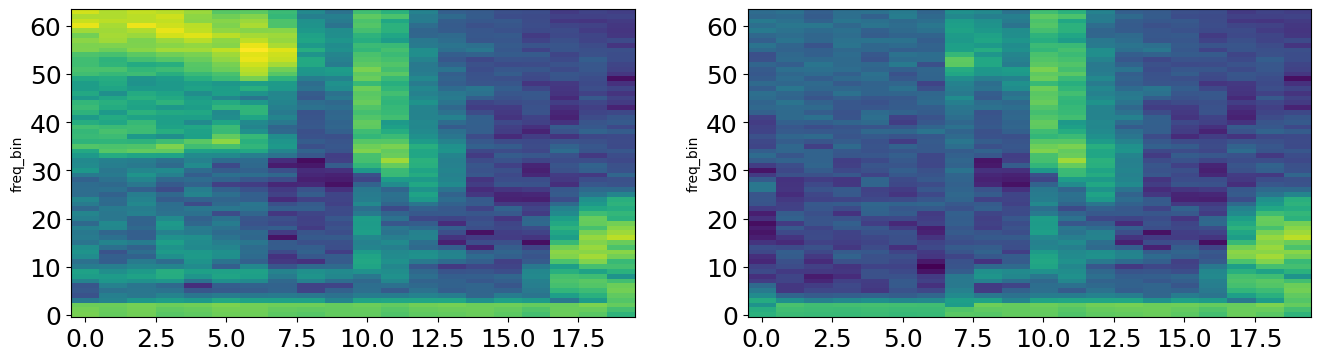

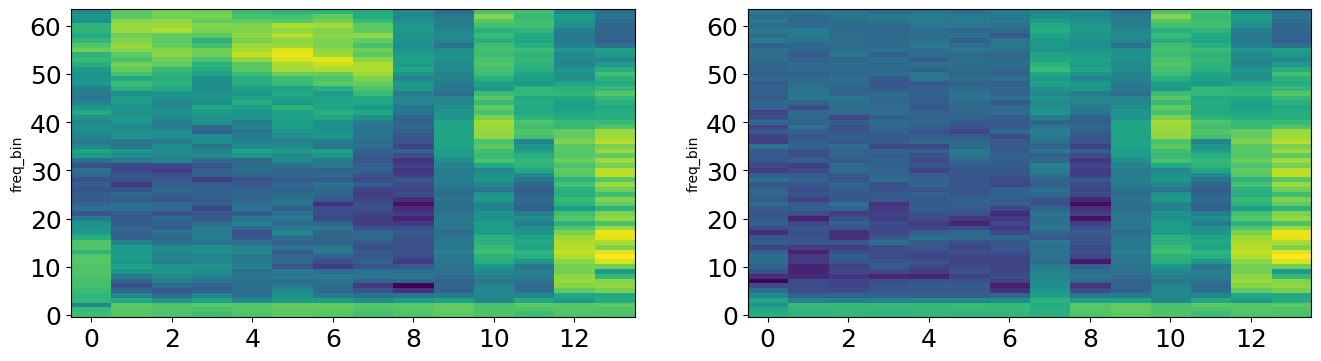

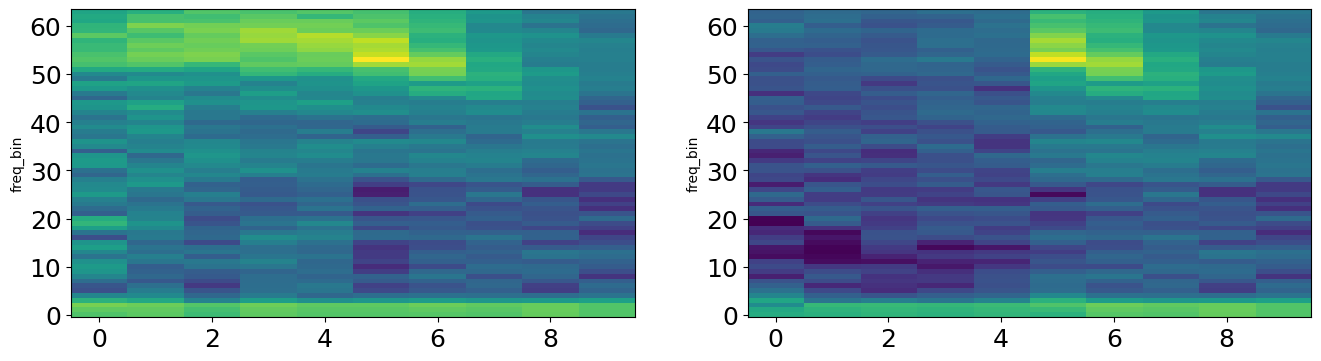

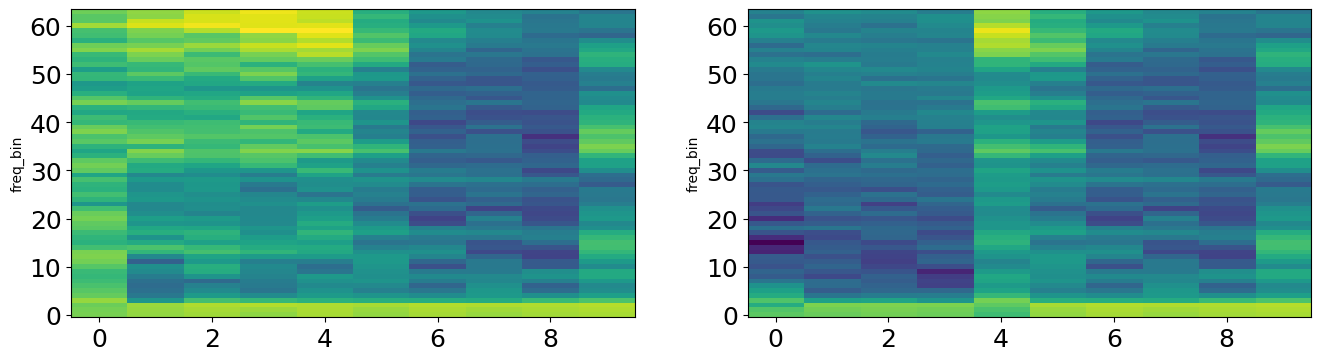

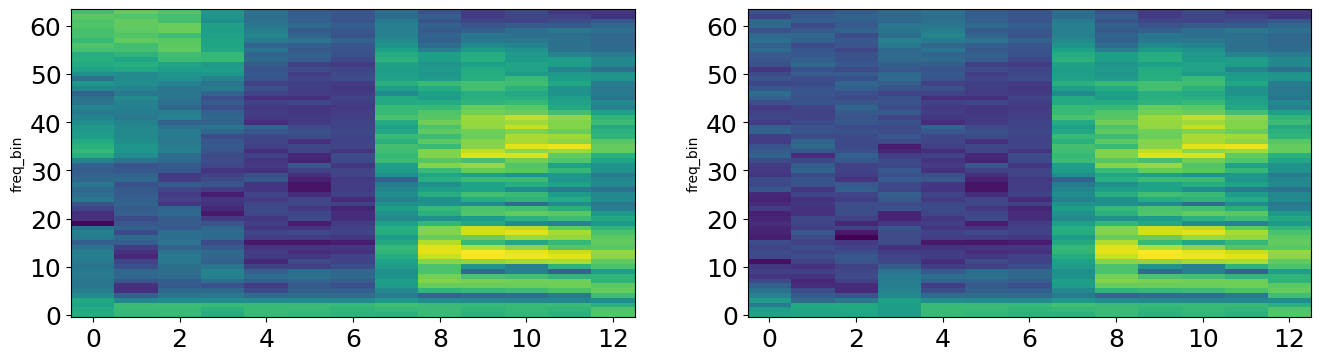

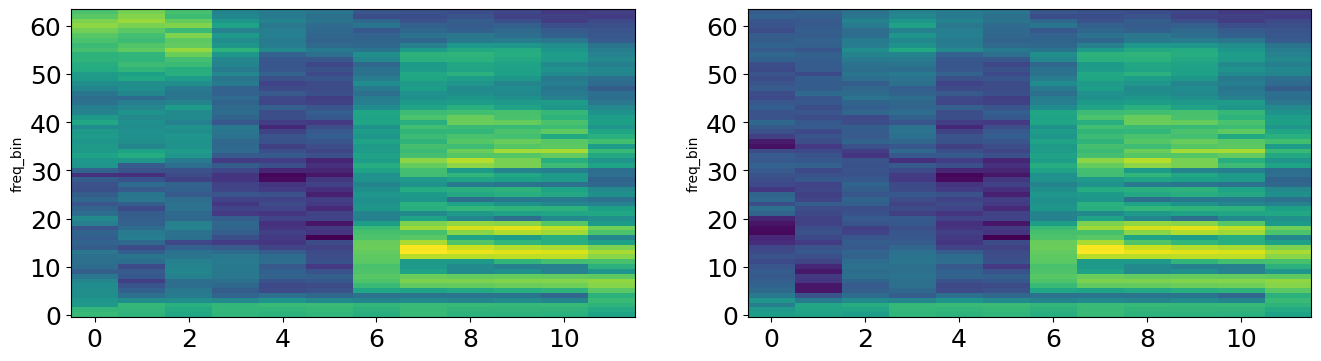

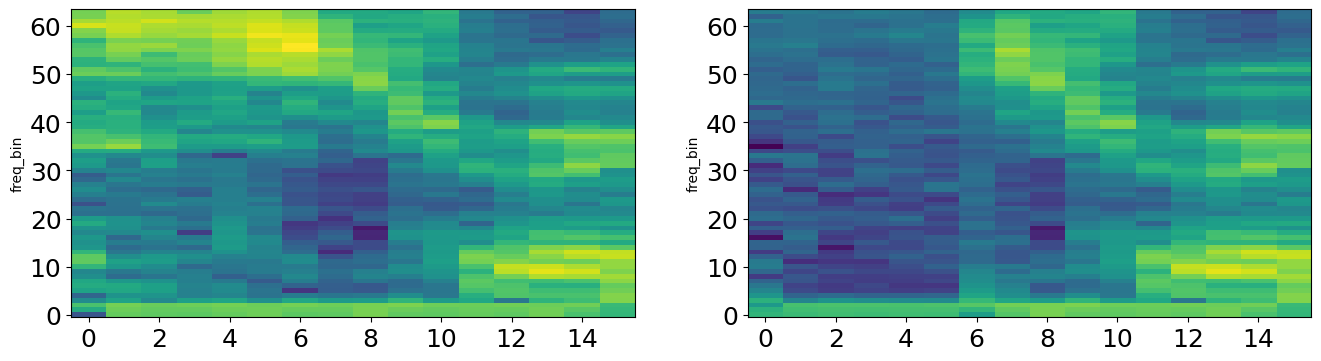

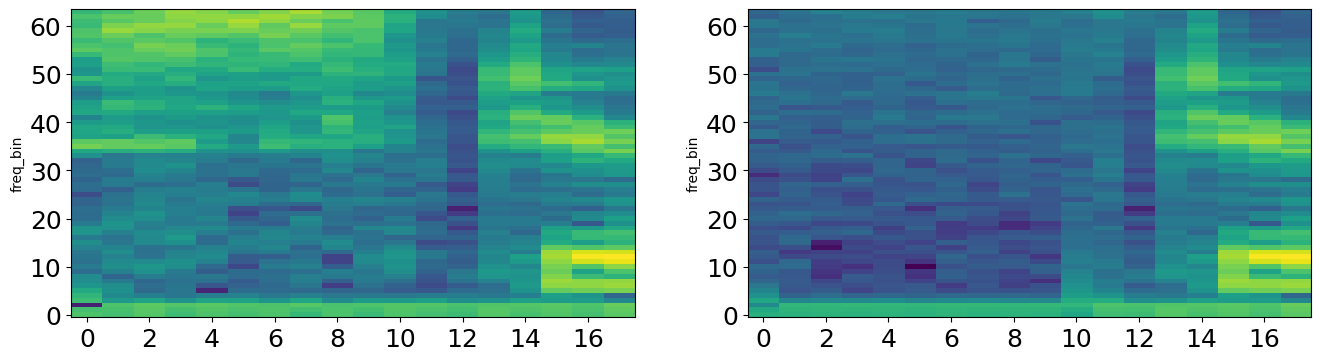

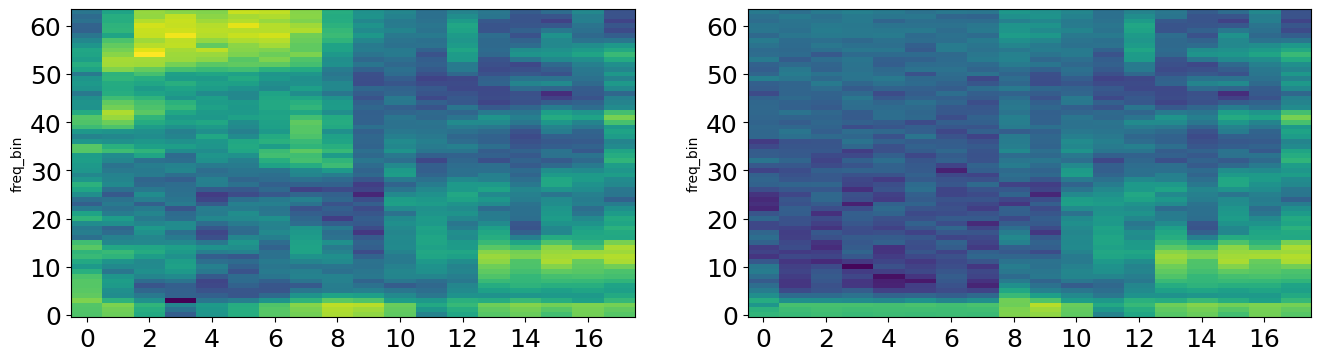

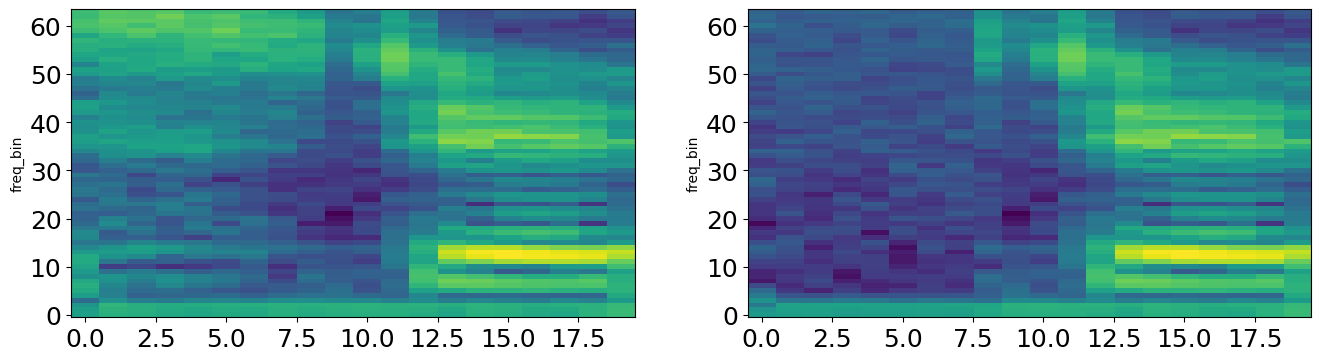

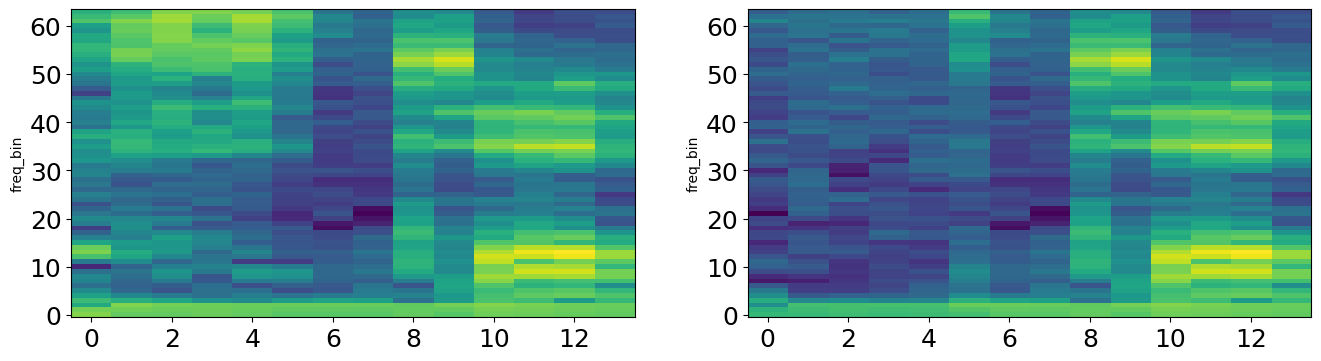

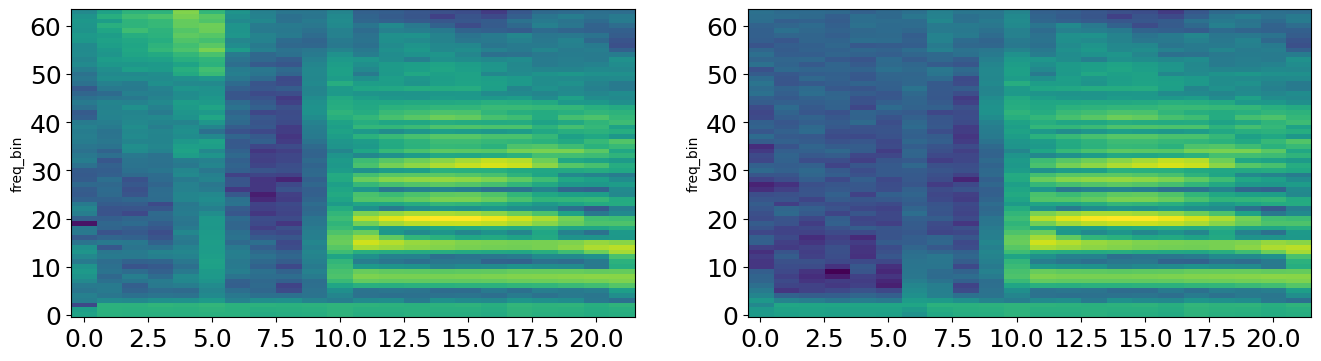

In [42]:
fs = 16000  # Sampling frequency (Hz)
duration = 0.05  # Duration in seconds
f0 = 60  # Fundamental frequency (F0 in Hz)
amplitude = 0.004  # Amplitude
oscillation_amplitude = 0.001

for rownum in range(guide_file_valid.shape[0]): 
    row = guide_file_valid.iloc[rownum]
    if guide_file_valid.iloc[rownum]["segment_nostress"]in ["S"] and guide_file_valid.iloc[rownum + 1]["segment_nostress"] in ["P", "T", "K"]: 
        pre_name = os.path.join(train_cut_phone_, row["phone_path"])
        T_name = os.path.join(train_cut_phone_, guide_file_valid.iloc[rownum + 1]["phone_path"])
        V_name_1 = os.path.join(train_cut_phone_, guide_file_valid.iloc[rownum + 2]["phone_path"])
        pre_data, sample_rate_pre = torchaudio.load(pre_name, normalize=True)
        T_data, sample_rate_T = torchaudio.load(T_name, normalize=True)
        V_data_1, sample_rate_V = torchaudio.load(V_name_1, normalize=True)

        data_1 = torch.cat([pre_data, T_data, V_data_1], dim=1)

        combined_signal = generate_harmonic_noise(pre_data.shape[1] / sample_rate_pre, 
                                                     sample_rate=fs, f0=f0, amplitude=amplitude, 
                                                     oscillation_amplitude=oscillation_amplitude)
        data_2 = torch.cat([combined_signal, T_data, V_data_1], dim=1)

        mel_1 = mytrans_nonorm(data_1)
        mel_2 = mytrans_nonorm(data_2)

        plot_spectrogram_both(mel_1.T, mel_2.T)
    if rownum > 5000: 
        break

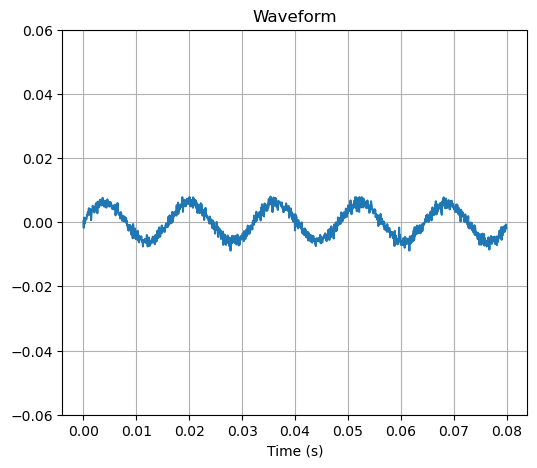

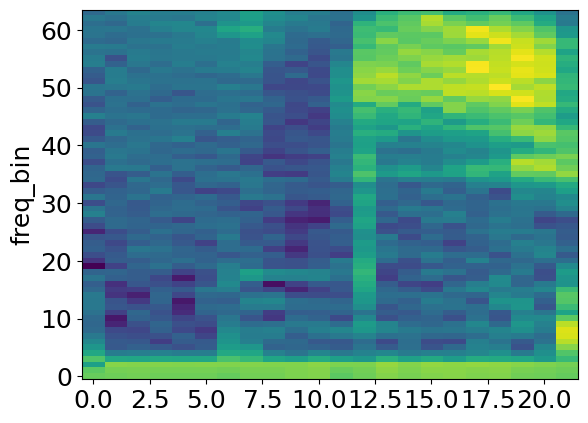

In [134]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 16000  # Sampling frequency (Hz)
duration = 0.05  # Duration in seconds
f0 = 62  # Fundamental frequency (F0 in Hz)
amplitude = 0.006  # Amplitude
oscillation_amplitude = 0.001

combined_signal, t = generate_harmonic_noise(pre_data.shape[1] / sample_rate_pre, sample_rate=fs, f0=f0, amplitude=amplitude, oscillation_amplitude=oscillation_amplitude)

# Plot the result (similar to the uploaded image)
plt.figure(figsize=(6, 5))
plt.plot(t, combined_signal)  # Show a portion of the signal
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylim(-0.06, 0.06)
plt.grid(True)
plt.show()

data_3 = torch.cat([torch.tensor(combined_signal, dtype=torch.float32).unsqueeze(0), T_data, V_data_1], dim=1)

mel_3 = mytrans(data_3)
plot_spectrogram_lined(mel_3.T)

In [135]:
mel_1.shape, mel_2.shape, mel_3.shape

(torch.Size([22, 64]), torch.Size([22, 64]), torch.Size([22, 64]))

In [148]:
from scipy.spatial import distance

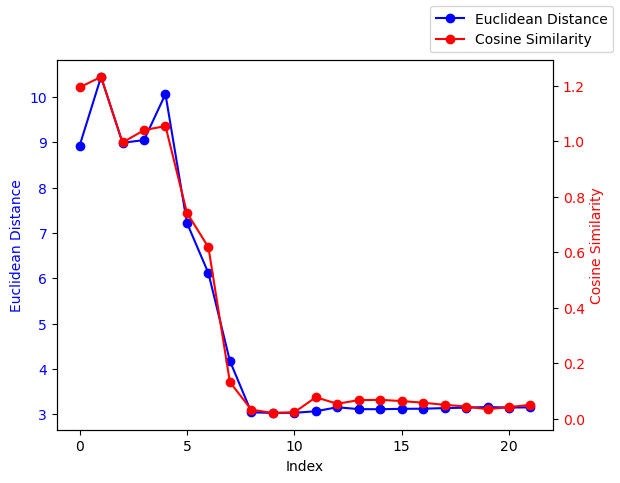

In [159]:
eucd = []
cosd = []
for i in range(len(mel_1)): 
    eucd.append(euclidean_distance(mel_1[i].numpy(), mel_3[i].numpy()))
    cosd.append(distance.cosine(mel_1[i].numpy(), mel_3[i].numpy()))
    # cosd.append(F.cosine_similarity(mel_1[i].unsqueeze(0), mel_3[i].unsqueeze(0)).item())


fig, ax1 = plt.subplots()

ax1.plot(eucd, label='Euclidean Distance', color='blue', marker="o")
ax1.set_xlabel('Index')
ax1.set_ylabel('Euclidean Distance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(cosd, label='Cosine Similarity', color='red', marker="o")
ax2.set_ylabel('Cosine Similarity', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.legend()
plt.show()

In [207]:
i = 8
j = 12

distance.cosine(mel_1[i].numpy(), mel_3[i].numpy()), distance.cosine(mel_1[i].numpy(), mel_1[j].numpy()), euclidean_distance(mel_1[i].numpy(), mel_2[i].numpy()), euclidean_distance(mel_1[i].numpy(), mel_1[j].numpy())

(0.03219515085220337, 1.3849364817142487, 5.1044316, 12.797917)

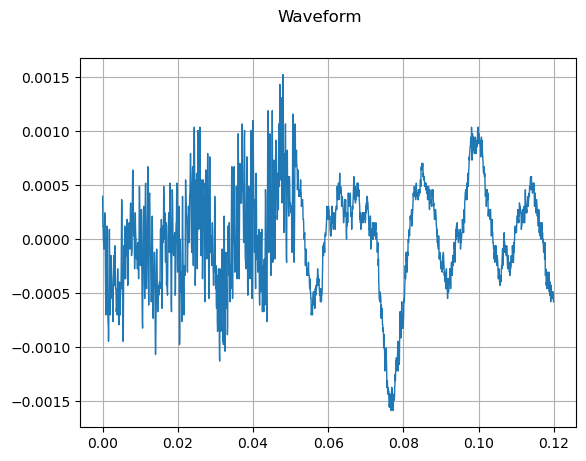

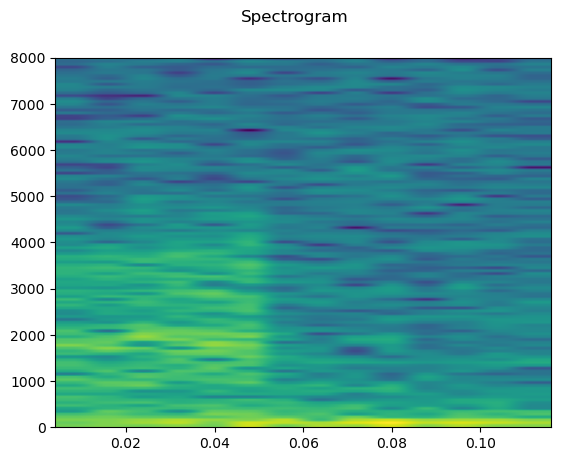

In [44]:
random_idx = random.randint(0, len(sil_fns) - 1)
fn = sil_fns[random_idx]

wav, sr = torchaudio.load(os.path.join(train_cut_phone_, fn))
plot_waveform(wav, sr)
plot_specgram(wav, sr)